# Human microbiome EASi-seq Data and Metagenomics Data Intergration

## HM3 Metagenomics Data Processing

raw read saved in folder: 
/drive1/xiangpeng/Project/bacteria/HM3/RawReads/
HuEf_HM3_repA_S112_R1_001.fastq.gz  HuEf_HM3_repB_S124_R1_001.fastq.gz 
HuEf_HM3_repA_S112_R2_001.fastq.gz  HuEf_HM3_repB_S124_R2_001.fastq.gz 


#### step 1: Use assembled contigs (by Cecilia)
/drive1/xiangpeng/Project/bacteria/HM3/assembly/final_assembly.fasta

contig counts: 61607

#### step 2: make contig bt2 reference 

bowtie2-build -f --threads 32 /drive1/xiangpeng/Project/bacteria/HM3/assembly/final_assembly.fasta /drive1/xiangpeng/Project/bacteria/HM3/assembly/bt2/hm3

#### step 3: map reads to contigs

bowtie2 -p 32 -x /drive1/xiangpeng/Project/bacteria/HM3/assembly/bt2/hm3 -1 /drive1/xiangpeng/Project/bacteria/HM3/RawReads/HuEf_HM3_repA_S112_R1_001.fastq.gz,/drive1/xiangpeng/Project/bacteria/HM3/RawReads/HuEf_HM3_repB_S124_R1_001.fastq.gz -2 /drive1/xiangpeng/Project/bacteria/HM3/RawReads/HuEf_HM3_repA_S112_R2_001.fastq.gz,/drive1/xiangpeng/Project/bacteria/HM3/RawReads/HuEf_HM3_repB_S124_R2_001.fastq.gz -S /drive1/xiangpeng/Project/bacteria/HM3/assembly/hm3.sam 
```
59515287 reads; of these:
  59515287 (100.00%) were paired; of these:
    14987512 (25.18%) aligned concordantly 0 times
    40151290 (67.46%) aligned concordantly exactly 1 time
    4376485 (7.35%) aligned concordantly >1 times
    ----
    14987512 pairs aligned concordantly 0 times; of these:
      7648198 (51.03%) aligned discordantly 1 time
    ----
    7339314 pairs aligned 0 times concordantly or discordantly; of these:
      14678628 mates make up the pairs; of these:
        9519420 (64.85%) aligned 0 times
        2266952 (15.44%) aligned exactly 1 time
        2892256 (19.70%) aligned >1 times
92.00% overall alignment rate
```
samtools view /drive1/xiangpeng/Project/bacteria/HM3/assembly/hm3.sam |head | awk '{ print $1, $3, $5 }'  >  /drive1/xiangpeng/Project/bacteria/HM3/assembly/contig_mapped_hm3.tsv

#### step 4: extract reads according to contigs

samtools sort -@ 32 /drive1/xiangpeng/Project/bacteria/HM3/assembly/hm3.sam -o /drive1/xiangpeng/Project/bacteria/HM3/assembly/hm3_sorted.bam 
samtools index /drive1/xiangpeng/Project/bacteria/HM3/assembly/hm3_sorted.bam

contig list: 
grep '@SQ' /drive1/xiangpeng/Project/bacteria/HM3/assembly/hm3.sam > /drive1/xiangpeng/Project/bacteria/HM3/assembly/contig_ls.tsv  
#this file contains the header information of the contigs: 
'@SQ     SN:k141_211000_length_578043_cov_317.5206       LN:578043'

In [91]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scanpy as sc
import anndata
import os
import seaborn as sns
from matplotlib import colors
from matplotlib.colors import LogNorm, Normalize
from subprocess import check_output
import numpy as np

In [13]:
bam_dir = '/drive1/xiangpeng/Project/bacteria/HM3/assembly/'
base_dir = '/drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/'

In [ ]:
wk_dir = '/drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/kraken/'
output_dir = base_dir + 'analysis/'

In [3]:
contig_ls_file = bam_dir + 'contig_ls.tsv'
contig_ls_df = pd.read_csv(contig_ls_file, sep='\t',names = ['SQ', 'node', 'LN'])
contig_ls= contig_ls_df['node'].str.replace('SN:','').tolist()
len(contig_ls)

61607

In [6]:
# short read extraction according to contig mapping
# reads that mapped to individual contig are saved into seperate files
fa_dir =  base_dir+ 'fa/'
n = 0
print('total contigs count is {}'.format(len(contig_ls)))
bam_in = bam_dir+'hm3_sorted.bam'
for contig in contig_ls:
    contig_len = int(contig.split('_')[3])
    if contig_len >= 500: # output the contigs longer than 500
        n+=1
        if n% 10000==0:
            print('{} contigs with lengh more than 500 have been processed'.format(n))
        out_fa = fa_dir + contig+ '.fa'
        cmd = 'samtools view -b {} {}|samtools fasta > {}'.format(bam_in, contig, out_fa)
        #print(cmd)
        #os.system(cmd)
      

total contigs count is 61607
10000 contigs with lengh more than 500 have been processed
20000 contigs with lengh more than 500 have been processed
30000 contigs with lengh more than 500 have been processed
40000 contigs with lengh more than 500 have been processed
50000 contigs with lengh more than 500 have been processed
60000 contigs with lengh more than 500 have been processed


#### step 5: kraken2 analysis of short reads associated with each contig

In [43]:
## GTDB databases for kraken and bracken are saved in: /drive1/xiangpeng/reference/kraken2/GTDB_release95/
kraken_db = '/drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/'
bracken_db = '/drive1/xiangpeng/reference/kraken2/GTDB_release95/bracken/'
fa_dir =  base_dir+ 'fa/'
kraken_dir = base_dir + 'kraken/'

bar_uncls_df = pd.DataFrame(columns=['contig','unclassified_ratio','contig_len', 'read_count'])
n = 0
for contig in contig_ls:
    contig_len = int(contig.split('_')[3])
    if contig_len >= 500: # output the contigs longer than 500
        
        contig_fa = fa_dir + contig+ '.fa'
        rpt = kraken_dir + contig+ '.kraken' # kraken report
        outpt = kraken_dir + contig+ '.output' # kraken output
    
        kr_cmd = 'kraken2  --threads 64  --memory-mapping --db {} --report {} --output {} {}'.format(kraken_db, rpt, outpt, contig_fa)
        #print(kr_cmd)
        #os.system(kr_cmd)  # run the command to process the short read fasta files with kraken2
    
        bracken_out =  kraken_dir + contig+ '_G.bracken' # bracken genues level output
        br_cmd = 'bracken -d {} -l G -i {} -o {}'.format(bracken_db, rpt, bracken_out)
        #print(br_cmd)
        #os.system(br_cmd) # run the command to process the kraken2 report using bracken  
    
        # read the first line of the report and get the unmapped read ratio
        rpt_file = open(rpt, "r")
        first_line = rpt_file.readline()
        second_line = rpt_file.readline()
        rpt_file.close()
        
        try:  
            read_cnt = 0 
            uncls_rate = float(first_line.split('\t')[0].strip(' '))
            
            if second_line != '':
                read_cnt += int(first_line.split('\t')[1]) 
                read_cnt += int(second_line.split('\t')[1])
            else:
                read_cnt += int(first_line.split('\t')[1])
                
            bar_uncls_df.loc[len(bar_uncls_df)]= [contig, uncls_rate, contig_len, read_cnt]
        except:
            continue
        
        if n% 10000==0:
            print('{} contigs with lengh more than 500 have been processed'.format(n))
        n += 1
        
bar_uncls_df = bar_uncls_df.set_index('contig') # set the contigs as index
bar_uncls_df['classified_ratio'] = 100 - bar_uncls_df['unclassified_ratio'] # calculate the ratio of reads that were mapped to the kraken database
bar_uncls_df.to_csv(output_dir + 'contig_kraken_unclassified_ratio.csv') # save the file 

0 contigs with lengh more than 500 have been processed
10000 contigs with lengh more than 500 have been processed
20000 contigs with lengh more than 500 have been processed
30000 contigs with lengh more than 500 have been processed
40000 contigs with lengh more than 500 have been processed
50000 contigs with lengh more than 500 have been processed
60000 contigs with lengh more than 500 have been processed


array([[<AxesSubplot:title={'center':'classified_ratio'}>]], dtype=object)

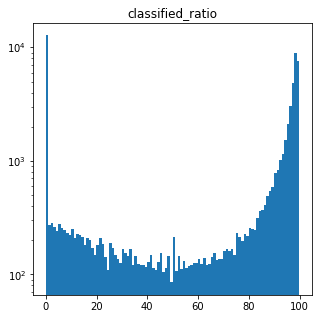

In [44]:
bar_uncls_df.hist(column = 'classified_ratio', bins = 100, grid = False, figsize =(5,5), log = True)

array([[<AxesSubplot:title={'center':'read_count'}>]], dtype=object)

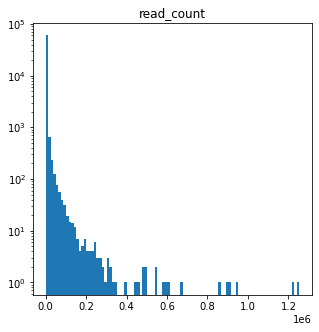

In [45]:
bar_uncls_df.hist(column = 'read_count', bins = 100, grid = False, figsize =(5,5), log = True)

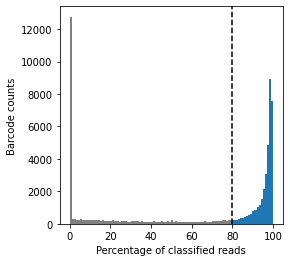

In [46]:
data = bar_uncls_df['classified_ratio'].tolist()
min_map = 80
fig, ax = plt.subplots(figsize=(4,4))
N,bins,patches = ax.hist(data, bins =100,)#edgecolor = 'white', linewidth =1,)
plt.axvline(x=min_map, color='k', linestyle='--', label='Cell Threshold')

for i in range(0,min_map):    
    patches[i].set_facecolor('grey')
plt.xlabel('Percentage of classified reads')#, fontsize=16)
plt.ylabel('Barcode counts')#, fontsize=16)
#plt.title('Perentage of reads not classified by Kraken', fontsize = 16)
plt.savefig(output_dir +'hm3_contigs_filter_by_kraken_map_rate_2.pdf',bbox_inches='tight')
plt.show()

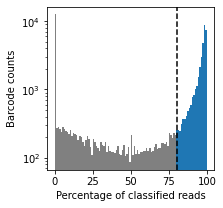

In [47]:
data = bar_uncls_df['classified_ratio'].tolist()
min_map = 80
fig, ax = plt.subplots(figsize=(3,3))
N,bins,patches = ax.hist(data, bins =100,log = True)#edgecolor = 'white', linewidth =1,)
plt.axvline(x=min_map, color='k', linestyle='--', label='Cell Threshold')

for i in range(0,min_map):    
    patches[i].set_facecolor('grey')
plt.xlabel('Percentage of classified reads')#, fontsize=16)
plt.ylabel('Barcode counts')#, fontsize=16)

#plt.title('Perentage of reads not classified by Kraken', fontsize = 16)
plt.savefig(output_dir +'hm3_contigs_filter_by_kraken_map_rate_log_scale_2.pdf',bbox_inches='tight')
plt.show()

In [49]:
filtered_contig =  bar_uncls_df[bar_uncls_df['classified_ratio']>=min_map].index.to_list()
len(filtered_contig)

35647

In [62]:
# read the bracken files
gns_abd =pd.DataFrame()

for contig in filtered_contig:
    bk_file =  kraken_dir + contig+ '_G.bracken' # bracken genues level output
    try:
        df = pd.read_csv(bk_file, sep = '\t')
    
        df = df.set_index('name')
        df = df.rename(columns = {'fraction_total_reads': contig})
        gns_abd = pd.concat([gns_abd, df[contig]], axis =1)
    except:
        continue 
        
        
gns_abd =  gns_abd.T  
gns_abd.to_csv(output_dir + 'HM3_metagenomics_contig_associated_read_genus_abundance.csv')

In [75]:
gns_abd_filtered=gns_abd.fillna(0)

gns_ls = gns_abd_filtered.columns.tolist()
gns_abd_filtered['purity']=gns_abd_filtered[gns_ls].max(axis=1)
gns_abd_filtered['Genus']=gns_abd_filtered[gns_ls].idxmax(axis=1)
gns_abd_filtered['read_count'] = bar_uncls_df['read_count']
gns_abd_filtered.head()

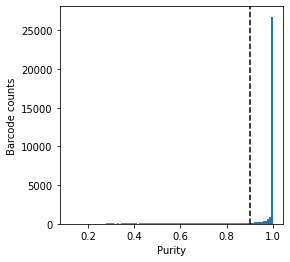

In [72]:
min_purity = 0.9
fig, ax = plt.subplots(figsize=(4,4))
plt.axvline(x=0.9, color='k', linestyle='--', label='Cell Threshold')
n, bins, patches = plt.hist(gns_abd_filtered['purity'], bins=100)
for c,p in zip(bins, patches):
    if c < min_purity:
        plt.setp(p, 'facecolor', 'grey')

plt.xlabel('Purity')#, fontsize=16)
plt.ylabel('Barcode counts')#, fontsize=16)
#plt.title('Perentage of reads not classified by Kraken', fontsize = 16)
plt.savefig(output_dir+'hm3_contgs_filter_genus_level_purity_2.pdf',bbox_inches='tight')

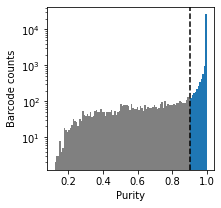

In [73]:
fig, ax = plt.subplots(figsize=(3,3))
plt.axvline(x=0.9, color='k', linestyle='--', label='Cell Threshold')
n, bins, patches = plt.hist(gns_abd_filtered['purity'], bins=100)
for c,p in zip(bins, patches):
    if c < min_purity:
        plt.setp(p, 'facecolor', 'grey')

plt.xlabel('Purity')#, fontsize=16)
plt.ylabel('Barcode counts')#, fontsize=16)
plt.yscale('log')
#plt.title('Perentage of reads not classified by Kraken', fontsize = 16)
plt.savefig(output_dir+'hm3_contgs_filter_genus_level_purity_log_2.pdf',bbox_inches='tight')

In [77]:
gns_abd_filtered.to_csv(output_dir + 'HM3_metagenomics_contig_associated_read_genus_abundance_purity_filtered.csv',  encoding='utf-8')

#### step 6: combine metagenomic dataset and EASi-seq dataset

1. single cell anndata:

/drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/analysis_gtdb/hm3_sc_genus_level_filtered_adata.h5ad


2. contig data frame: 
/drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/analysis/hm3_contigs_genus_kraken_abandance_filtered.csv

In [136]:
sc.settings.verbosity = 3  
sc.settings.set_figure_params(dpi=80, frameon=True, figsize=(5, 5), facecolor='white')

In [137]:
# Read the HM3 EASi-seq data
adata_sc = anndata.read_h5ad('/drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/analysis_gtdb/hm3_sc_genus_level_filtered_adata.h5ad')
adata_sc

AnnData object with n_obs × n_vars = 1122 × 3175
    obs: 'leiden', 'celltype', 'cluster'
    uns: 'celltype_colors', 'cluster_colors', "dendrogram_['cluster']", 'dendrogram_cluster', 'leiden', 'leiden_colors', 'neighbors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

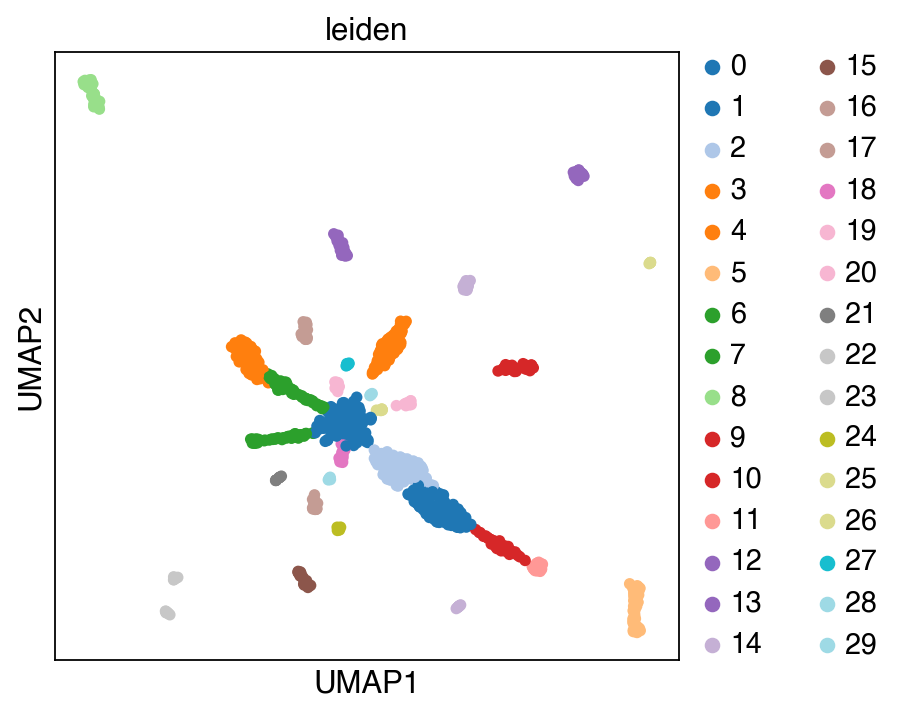

In [138]:
sc.pl.umap(adata_sc, color = 'leiden')

In [139]:
# covert the metagenomic contig data to anndata 
adata_contig=anndata.AnnData(gns_abd_filtered.drop(columns = ['purity','Genus', 'read_count']), 
                             dtype=np.float32
                            )


In [140]:
# in order to use ingest function to merge the 2 type dataset, they must have same variables
# we plan to include all the variable
contig_add = adata_sc.var_names.difference(adata_contig.var_names)# new variables the contig data need to add
sc_add = adata_contig.var_names.difference(adata_sc.var_names)# new variables the easi-seq data need to add. 
print(len(sc_add),len(contig_add))

1446 1138


In [141]:
# add all 0 matrix to the contig data with the variables need to add as the variable name. 
contig_add_ad =  anndata.AnnData(
    X=np.zeros((adata_contig.shape[0],len(contig_add)), dtype = int),
    obs = adata_contig.obs,
    var = pd.DataFrame(index =contig_add)
)

adata_contig =anndata.concat([adata_contig,contig_add_ad], axis =1)
adata_contig

/tmp/ipykernel_83508/2287755969.py:1: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  contig_add_ad =  anndata.AnnData(


AnnData object with n_obs × n_vars = 35294 × 4621

In [142]:
# add all 0 matrix to the easi-seq data with the variables need to add as the variable name.
sc_add_ad =  anndata.AnnData(
    X=np.zeros((adata_sc.shape[0],len(sc_add)), dtype = int),
    obs = adata_sc.obs,
    var = pd.DataFrame(index =sc_add)
)

adata_sc =anndata.concat([adata_sc,sc_add_ad], axis =1)
adata_sc

/tmp/ipykernel_83508/2156134910.py:1: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  sc_add_ad =  anndata.AnnData(


AnnData object with n_obs × n_vars = 1122 × 4621

In [143]:
#find common variables in both datasets
var_names =adata_sc.var_names.intersection(adata_contig.var_names)
adata_sc = adata_sc[:,var_names] # reorder the data
adata_contig=adata_contig[:, var_names] # reorder the data

In [144]:
sc.pp.pca(adata_sc)
sc.pp.neighbors(adata_sc)
sc.tl.umap(adata_sc)
sc.tl.leiden(adata_sc)

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)
running Leiden clustering
    finished: found 32 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


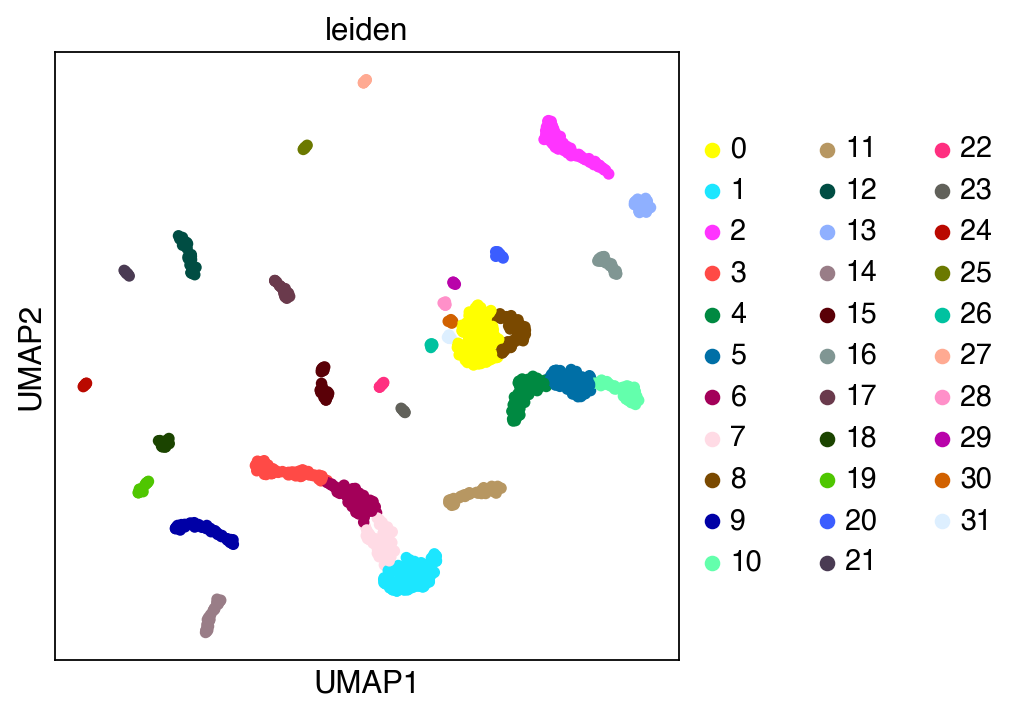

In [145]:
sc.pl.umap(adata_sc,color ='leiden')

In [146]:
sc.tl.ingest(adata_contig, adata_sc, obs = 'leiden') # use ingest function to combine the 2 datasets. 

running ingest
    finished (0:02:11)


In [147]:
adata_contig.uns['leiden_colors'] = adata_sc.uns['leiden_colors']

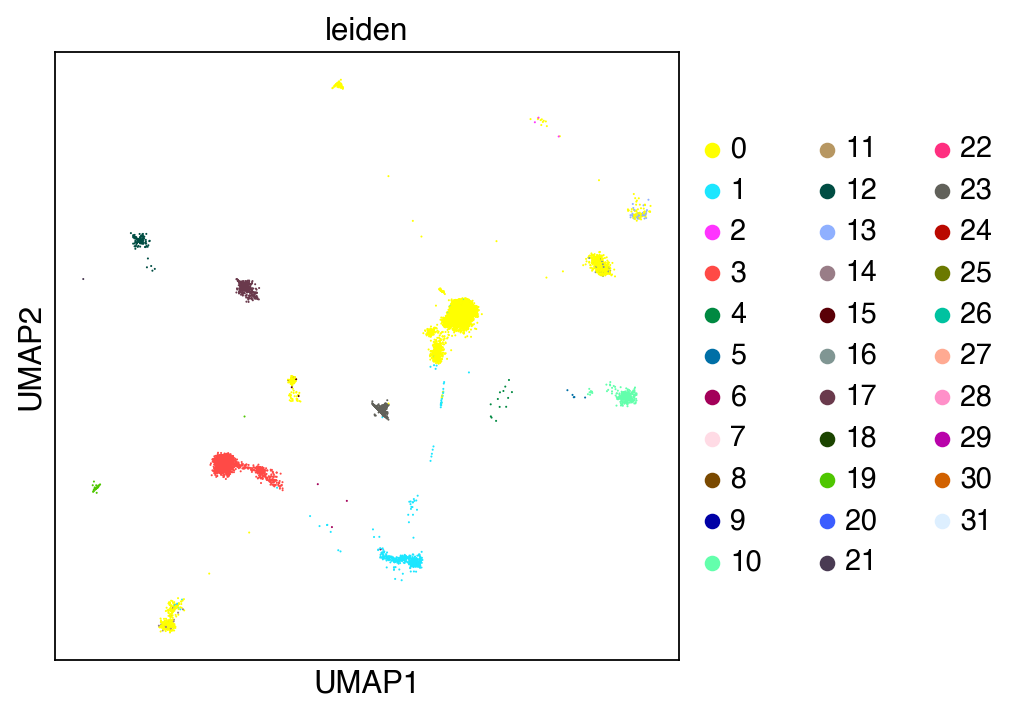

In [148]:
sc.pl.umap(adata_contig, color=['leiden'], wspace=0.5)

In [149]:
adata_concat = adata_sc.concatenate(adata_contig, batch_categories=['single_cell', 'contig'])

/usr/local/lib/python3.9/dist-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [150]:
adata_concat.obs.leiden = adata_concat.obs.leiden.astype('category')
adata_concat.obs.leiden.cat.reorder_categories(adata_sc.obs.leiden.cat.categories, inplace = True)
adata_concat.uns['leiden_colors']=adata_sc.uns['leiden_colors']

/tmp/ipykernel_83508/1521127557.py:2: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata_concat.obs.leiden.cat.reorder_categories(adata_sc.obs.leiden.cat.categories, inplace = True)


In [151]:
print(adata_concat.shape)
sc.pp.filter_cells(adata_concat, min_counts = 0.99)
print(adata_concat.shape)

(36416, 4621)
filtered out 633 cells that have less than 0.99 counts
(35783, 4621)


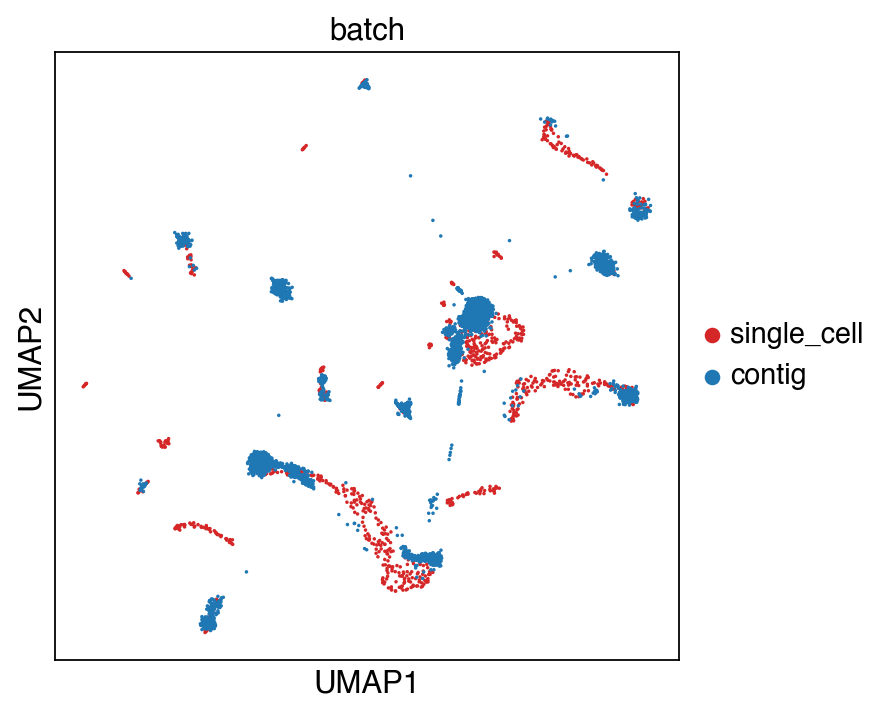

In [152]:
batch_colors = ['tab:red', 'tab:blue']
sc.pl.umap(adata_concat, color=['batch'], size = 10, palette=batch_colors)

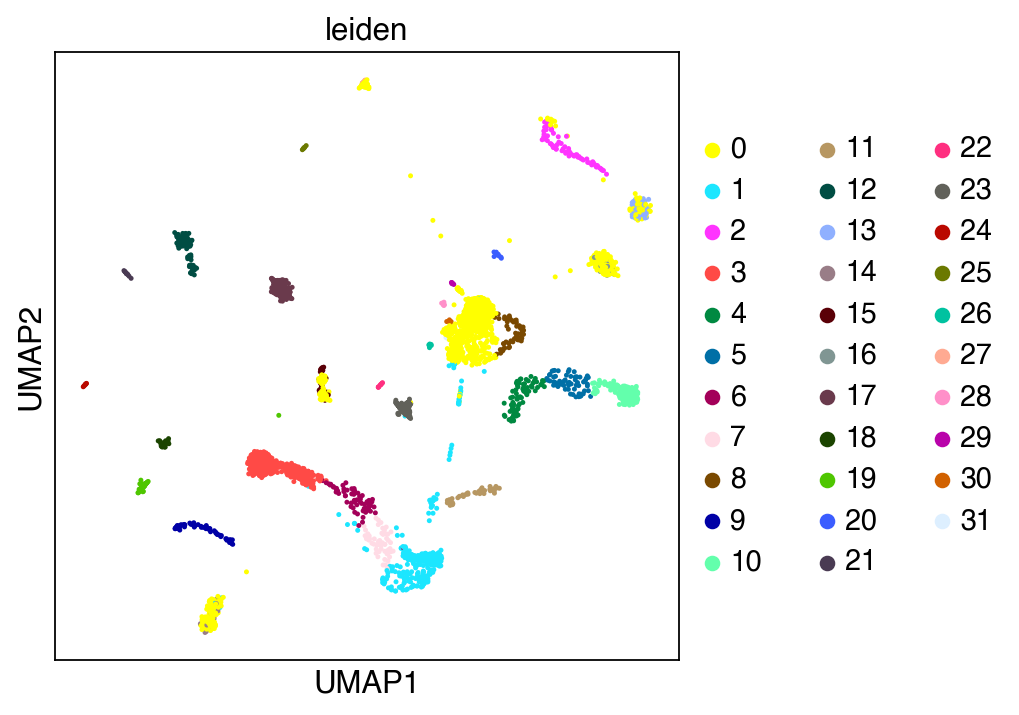

In [153]:
sc.pl.umap(adata_concat, color=[ 'leiden'], size = 20)

In [ ]:
cell_type_df = adata_concat.to_df()
cell_type_df['cell_type'] = cell_type_df.idxmax(axis=1) # assign the dominant genus in each barcode group as the cell type. 

cell_type_dict = cell_type_df['cell_type'].to_dict()
cell_type_count = cell_type_df['cell_type'].value_counts().to_dict()

<AxesSubplot:ylabel='Frequency'>

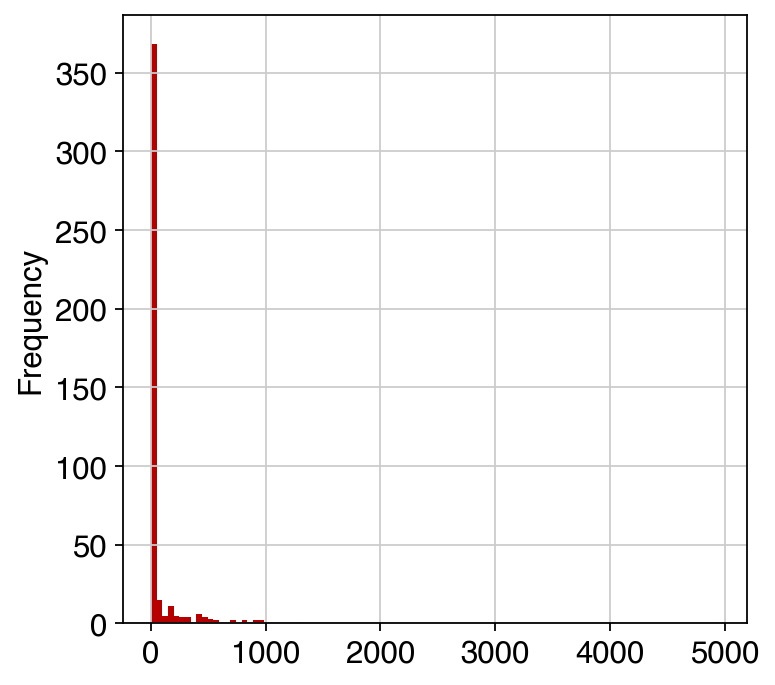

In [168]:
 cell_type_df['cell_type'].value_counts().plot.hist(bins=100)

In [155]:
min_cnt =50 ## if centain cell type have less than min_cnt barcodes/contigs, reclassify as 'other'
cell_type_dict_fixed = {}

for k in cell_type_dict:
    ctype = cell_type_dict[k]
    cnt = cell_type_count[ctype]
    if cnt >= min_cnt:
        cell_type_dict_fixed[k]=ctype.split('__')[1]
    else:
        cell_type_dict_fixed[k]='other'
        

In [158]:
adata_concat.obs['cell_type']= adata_concat.obs.index.map(cell_type_dict_fixed) # annotate each barcode with the corresponding genus. If the genus barcode count is less than 50, use 'other' 
adata_concat.obs['cell_type_2']= adata_concat.obs.index.map(cell_type_dict) # annotate each barcode with the corresponding genus. 

In [159]:
assigned_type =[]
for k in cell_type_dict:
    v = cell_type_dict[k]
    
    if v not in assigned_type and v != 'other':
        assigned_type.append(v)

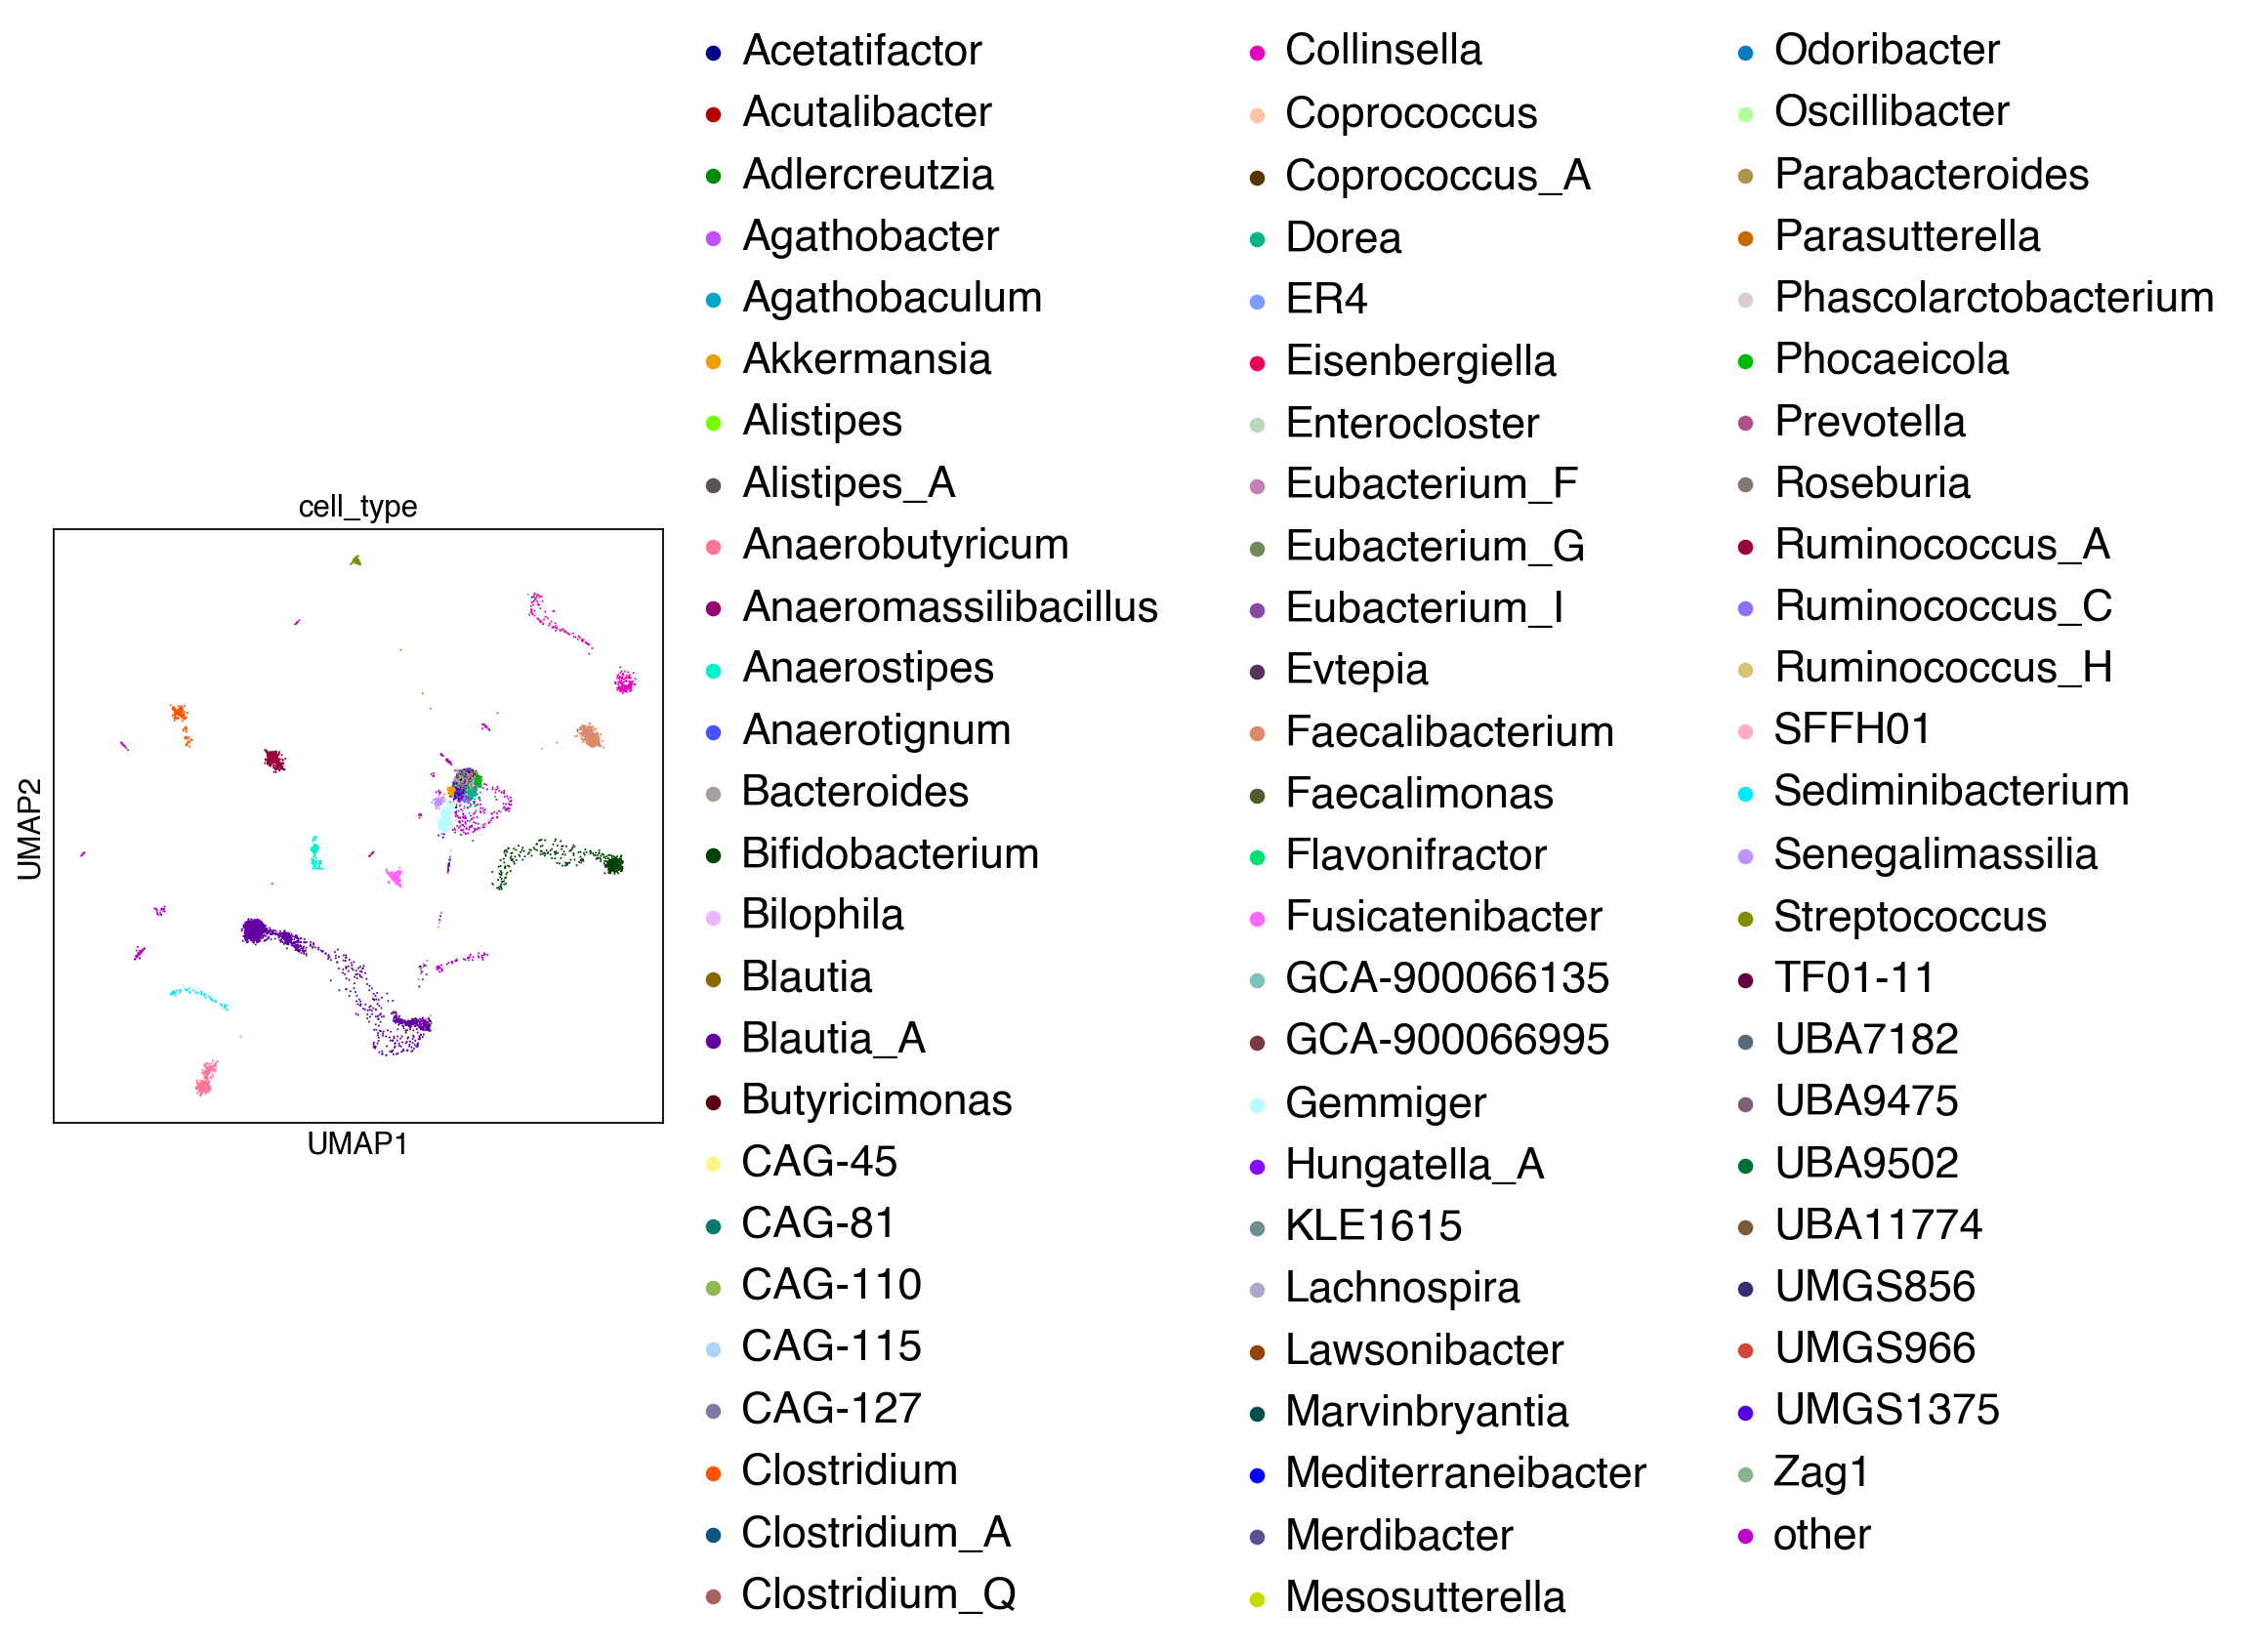

In [170]:
# custome color palette generated by glasbey.py
glasbey_257 = pd.read_csv('/drive1/xiangpeng/apps/glasbey/color257_hex.txt', names = ['color'])['color'].tolist()
glasbey = glasbey_257[1:1+len(adata_concat.obs['cell_type'].unique())]
sns.set_palette(sns.color_palette(glasbey))

sc.pl.umap(adata_concat, 
           color='cell_type', 
           #legend_loc='on data',
           legend_fontsize=20, 
           palette = sns.color_palette(glasbey)
           ) 

### extract pair end fastq of all contigs by cluster IDs.

In [190]:
cluster_df = adata_concat.obs
sc_bar_cnt = len(cluster_df[cluster_df['batch']=='single_cell'].index.to_list()) # single cell barcode counts
contig_bar_cnt = len(cluster_df[cluster_df['batch']=='contig'].index.to_list()) # contig barcode counts
print(sc_bar_cnt, contig_bar_cnt)

1118 34665


In [194]:
cluster_group_df = cluster_df.groupby(['cell_type_2']).size().reset_index().rename(columns={0:'count'})

cluster_group_df = cluster_group_df[cluster_group_df['count']>20]# filter out cluster with less than 20 barcodes
cluster_ID_ls = cluster_group_df.cell_type_2.unique().tolist()

In [240]:
fq_dir = '/drive1/xiangpeng/Project/bacteria/HM3/assembly/'
header_file = fq_dir + 'contig_mapped_hm3.tsv'
qrnames = pd.read_csv(header_file,sep =' ', names = ['read','contig', 'qscore'])
qrnames = qrnames[qrnames['contig']!='*'] # remove unaligned reads
qrnames = qrnames[qrnames['qscore']>=42] # filter the reads by qscore

# extract pair-end short read from the contigs.
contig_out_dir = '/drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/contigs/'
raw_dir = '/drive1/xiangpeng/Project/bacteria/HM3/RawReads'
raw_fq1 = raw_dir + 'HM3_R1.fastq.gz'
raw_fq2 = raw_dir + 'HM3_R2.fastq.gz'

cluster_stat = pd.DataFrame(columns=['cluster', 'contig_bar_cnt','contig_read_cnt'])


for c in cluster_ID_ls:
    idx_ls = cluster_df[(cluster_df['cell_type_2']==c)&(cluster_df['batch']=='contig')].index.tolist()
    contig_bar_cnt = len(idx_ls)
    
    idx_ls_contig = []
    
    print('Processing {}, totally {} contigs'.format(c, len(idx_ls)))
    
    
    ## index in the cluster_df matrix have the following format:
    ### k141_33614_length_1000_cov_8.0000-contig
    #### need to remove the '-contig' string from each line.
    idx_ls_contig = []
    for idx in idx_ls:
        new_idx = idx.split('-')[0]
        idx_ls_contig.append(new_idx)
    
    # select the qrnames with the right contigs
    df = qrnames[qrnames['contig'].isin(idx_ls_contig)]
    # get the header of all reads associated with all contigs belongs to one cluster. 
    read_ls =  df['read'].unique().tolist()
    contig_read_cnt = len(read_ls)
    
    
    # save the read id as a txt 
    read_file = contig_out_dir + c + '-contig-associated-reads.txt'
    #file = open(read_file, 'w')
    #for r in read_ls:
        #file.write(r+'\n')
    #file.close()
    print('Contig associated read header for {} have been saved in file: {}!'.format(c, read_file))
          
          
    # extract the reads from fastq files with seqtk command line tool
    out_1 = contig_out_dir + c + '_combined_R1.fq'
    out_2 = contig_out_dir + c + '_combined_R2.fq'
    seqtk_cmd1 = 'seqtk subseq {} {} > {}'.format(raw_fq1, read_file, out_1)
    seqtk_cmd2 = 'seqtk subseq {} {} > {}'.format(raw_fq2, read_file, out_2)
    #os.system(seqtk_cmd1)
    #os.system(seqtk_cmd2)
    print('Pair end reads of {} contigs have been saved in file: {} and {} !'.format(c, out_1, out_2))
    print('Finished processing {}!'.format(c))
    
    cluster_stat.loc[len(cluster_stat)] = [c, contig_bar_cnt, contig_read_cnt]
cluster_stat = cluster_stat.set_index('cluster')
qrnames =[] # remove the qrnames from the memory

Processing g__Acetatifactor, totally 835 contigs
Contig associated read header for g__Acetatifactor have been saved in file: /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/contigs/g__Acetatifactor-contig-associated-reads.txt!
Pair end reads of g__Acetatifactor contigs have been saved in file: /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/contigs/g__Acetatifactor_combined_R1.fq and /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/contigs/g__Acetatifactor_combined_R2.fq !
Finished processing g__Acetatifactor!
Processing g__Acutalibacter, totally 91 contigs
Contig associated read header for g__Acutalibacter have been saved in file: /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/contigs/g__Acutalibacter-contig-associated-reads.txt!
Pair end reads of g__Acutalibacter contigs have been saved in file: /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/contigs/g__Acutalibacter_combined_R1.fq and /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitt

Contig associated read header for g__Barnesiella have been saved in file: /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/contigs/g__Barnesiella-contig-associated-reads.txt!
Pair end reads of g__Barnesiella contigs have been saved in file: /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/contigs/g__Barnesiella_combined_R1.fq and /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/contigs/g__Barnesiella_combined_R2.fq !
Finished processing g__Barnesiella!
Processing g__Bifidobacterium, totally 277 contigs
Contig associated read header for g__Bifidobacterium have been saved in file: /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/contigs/g__Bifidobacterium-contig-associated-reads.txt!
Pair end reads of g__Bifidobacterium contigs have been saved in file: /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/contigs/g__Bifidobacterium_combined_R1.fq and /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/contigs/g__Bifidobacterium_combined_R2.fq !
Fin

Contig associated read header for g__Clostridium_A have been saved in file: /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/contigs/g__Clostridium_A-contig-associated-reads.txt!
Pair end reads of g__Clostridium_A contigs have been saved in file: /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/contigs/g__Clostridium_A_combined_R1.fq and /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/contigs/g__Clostridium_A_combined_R2.fq !
Finished processing g__Clostridium_A!
Processing g__Clostridium_Q, totally 541 contigs
Contig associated read header for g__Clostridium_Q have been saved in file: /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/contigs/g__Clostridium_Q-contig-associated-reads.txt!
Pair end reads of g__Clostridium_Q contigs have been saved in file: /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/contigs/g__Clostridium_Q_combined_R1.fq and /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/contigs/g__Clostridium_Q_combined_R2.fq !
Fin

Contig associated read header for g__Faecalimonas have been saved in file: /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/contigs/g__Faecalimonas-contig-associated-reads.txt!
Pair end reads of g__Faecalimonas contigs have been saved in file: /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/contigs/g__Faecalimonas_combined_R1.fq and /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/contigs/g__Faecalimonas_combined_R2.fq !
Finished processing g__Faecalimonas!
Processing g__Flavonifractor, totally 465 contigs
Contig associated read header for g__Flavonifractor have been saved in file: /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/contigs/g__Flavonifractor-contig-associated-reads.txt!
Pair end reads of g__Flavonifractor contigs have been saved in file: /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/contigs/g__Flavonifractor_combined_R1.fq and /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/contigs/g__Flavonifractor_combined_R2.fq !
Fin

Contig associated read header for g__Merdibacter have been saved in file: /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/contigs/g__Merdibacter-contig-associated-reads.txt!
Pair end reads of g__Merdibacter contigs have been saved in file: /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/contigs/g__Merdibacter_combined_R1.fq and /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/contigs/g__Merdibacter_combined_R2.fq !
Finished processing g__Merdibacter!
Processing g__Mesosutterella, totally 283 contigs
Contig associated read header for g__Mesosutterella have been saved in file: /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/contigs/g__Mesosutterella-contig-associated-reads.txt!
Pair end reads of g__Mesosutterella contigs have been saved in file: /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/contigs/g__Mesosutterella_combined_R1.fq and /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/contigs/g__Mesosutterella_combined_R2.fq !
Finished 

Contig associated read header for g__Ruthenibacterium have been saved in file: /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/contigs/g__Ruthenibacterium-contig-associated-reads.txt!
Pair end reads of g__Ruthenibacterium contigs have been saved in file: /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/contigs/g__Ruthenibacterium_combined_R1.fq and /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/contigs/g__Ruthenibacterium_combined_R2.fq !
Finished processing g__Ruthenibacterium!
Processing g__SFFH01, totally 470 contigs
Contig associated read header for g__SFFH01 have been saved in file: /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/contigs/g__SFFH01-contig-associated-reads.txt!
Pair end reads of g__SFFH01 contigs have been saved in file: /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/contigs/g__SFFH01_combined_R1.fq and /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/contigs/g__SFFH01_combined_R2.fq !
Finished processing g__SFFH

### Group single cell reads by cluster 

In [246]:
sc_out_dir = '/drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell/'
fq_dir = '/drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/fq/'
analysis_dir = '/drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/analysis/'
cluster_stat['sc_bar_cnt'] = 0 
cluster_stat['sc_read_cnt']=0

for c in cluster_ID_ls:
    c_dir = sc_out_dir + c +'/'
    mkdir_cmd = 'mkdir {}'.format(c_dir)
    print(mkdir_cmd)
    #os.system(mkdir_cmd)
    
    idx_ls = cluster_df[(cluster_df['cell_type_2']==c)&(cluster_df['batch']=='single_cell')].index.tolist()
    
    bar_ls =  [s.replace('-single_cell', '') for s in idx_ls]
    
    bar_cnt = len(idx_ls)
    print('In {} cluster, there are totally {} barcodes'.format(c, bar_cnt))
    df = bar_uncls_df.loc[bar_ls]
    sc_read_cnt = df['read_count'].sum()
    cluster_stat.loc[c, 'sc_bar_cnt']= bar_cnt
    cluster_stat.loc[c,'sc_read_cnt']=sc_read_cnt
    
    # move all the fq and comine them 
    if bar_cnt >0:

        print(sc_read_cnt)
        print('copying fastq files for {}'.format(c))
        for bar in bar_ls:
        
            in_fq1 = fq_dir + bar + '_R1.fq'
            in_fq2 = fq_dir + bar + '_R2.fq'
            out_fq1 = c_dir + bar + '_R1.fq'
            out_fq2 = c_dir + bar + '_R2.fq'
            cp_cmd1 = 'cp {} {}'.format(in_fq1, out_fq1)
            cp_cmd2 = 'cp {} {}'.format(in_fq2, out_fq2)
            #os.system(cp_cmd1)
            #os.system(cp_cmd2)
        # combine all fq in a folder
        cat_cmd1 = 'cat {}*R1.fq > {}R1_combined.fastq'.format(c_dir, c_dir)
        cat_cmd2 = 'cat {}*R2.fq > {}R2_combined.fastq'.format(c_dir, c_dir)
   
        print(cat_cmd1, cat_cmd2)
        #os.system(cat_cmd1)
        #os.system(cat_cmd2)
        # remove barcode fq
        rm_cmd = 'rm {}*.fq'.format(c_dir)
        print(rm_cmd)
        #os.system(rm_cmd)
        

mkdir /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell/g__Acetatifactor/
In g__Acetatifactor cluster, there are totally 0 barcodes
mkdir /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell/g__Acutalibacter/
In g__Acutalibacter cluster, there are totally 0 barcodes
mkdir /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell/g__Adlercreutzia/
In g__Adlercreutzia cluster, there are totally 0 barcodes
mkdir /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell/g__Agathobacter/
In g__Agathobacter cluster, there are totally 0 barcodes
mkdir /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell/g__Agathobaculum/
In g__Agathobaculum cluster, there are totally 0 barcodes
mkdir /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell/g__Akkermansia/
In g__Akkermansia cluster, there are totally 4 barcodes
41946
copying fastq files for g__Akkermansia
cat /drive1/xiangpeng/Project/bacteria/HM3/assembly/spl

rm /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell/g__Blautia_A/*.fq
mkdir /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell/g__Butyricimonas/
In g__Butyricimonas cluster, there are totally 0 barcodes
mkdir /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell/g__Butyrivibrio_A/
In g__Butyrivibrio_A cluster, there are totally 0 barcodes
mkdir /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell/g__CAG-41/
In g__CAG-41 cluster, there are totally 0 barcodes
mkdir /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell/g__CAG-45/
In g__CAG-45 cluster, there are totally 0 barcodes
mkdir /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell/g__CAG-81/
In g__CAG-81 cluster, there are totally 0 barcodes
mkdir /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell/g__CAG-103/
In g__CAG-103 cluster, there are totally 0 barcodes
mkdir /drive1/xiangpeng/Project/bacteria/HM3/assembly/sp

cat /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell/g__Enterocloster/*R1.fq > /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell/g__Enterocloster/R1_combined.fastq cat /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell/g__Enterocloster/*R2.fq > /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell/g__Enterocloster/R2_combined.fastq
rm /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell/g__Enterocloster/*.fq
mkdir /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell/g__Eubacterium_F/
In g__Eubacterium_F cluster, there are totally 0 barcodes
mkdir /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell/g__Eubacterium_G/
In g__Eubacterium_G cluster, there are totally 0 barcodes
mkdir /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell/g__Eubacterium_I/
In g__Eubacterium_I cluster, there are totally 0 barcodes
mkdir /drive1/xiangpeng/Project/bacteria/HM3/as

cat /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell/g__Phocaeicola/*R1.fq > /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell/g__Phocaeicola/R1_combined.fastq cat /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell/g__Phocaeicola/*R2.fq > /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell/g__Phocaeicola/R2_combined.fastq
rm /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell/g__Phocaeicola/*.fq
mkdir /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell/g__Prevotella/
In g__Prevotella cluster, there are totally 1 barcodes
4622
copying fastq files for g__Prevotella
cat /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell/g__Prevotella/*R1.fq > /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell/g__Prevotella/R1_combined.fastq cat /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell/g__Prevotella/*R2.fq > /drive1/xiangpeng/Project/bac

### Assemble cluster reads

In [226]:
# assemble the barcodes reads with extracted contigs reads and quast evaluation

sc_read_dir = '/drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell/' 
spade = '/drive1/xiangpeng/apps/SPAdes-3.15.3-Linux/bin/spades.py' # Spades application
assemb_dir = '/drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/assemb_sc_contig/'
contig_read_dir = '/drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/contigs/'
quast_dir = '/drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/assemb_sc_contig_quast/'
analysis_dir = '/drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/analysis/'


for c in cluster_ID_ls:
    c_dir = sc_read_dir + c +'/'
    sc_1 = c_dir + 'R1_combined.fastq'
    sc_2 = c_dir + 'R2_combined.fastq'
    
    contig_1 = contig_read_dir + c + '_combined_R1.fq'
    contig_2 = contig_read_dir + c + '_combined_R2.fq'
    
    assembed_out = assemb_dir+c+'/'
    mkdir_cmd = 'mkdir {}'.format(assembed_out)
    print(mkdir_cmd)
    #os.system(mkdir_cmd)
    
    sc_cnt = int(cluster_stat.loc[c, 'sc_bar_cnt'])
    contig_cnt =int(cluster_stat.loc[c, 'contig_bar_cnt'])
    
    
    # if there are both EASi-seq and Metagenomic Contigs, co assembly all the reads
    if sc_cnt > 0 and contig_cnt >0:
        assemb_cmd =  'python  {} -o {} --sc --pe-1 1 {} --pe-2 1 {} --pe-1 2 {} --pe-2 2 {} -t 64 '.format(spade,
                                                                                                            assembed_out, 
                                                                                        sc_1, sc_2,
                                                                                        contig_1, contig_2)
        print(assemb_cmd)
        #os.system(assemb_cmd)
        
    # if there are just one EASi-seq or metagenomic contigs, only assemble the exist reads 
    if sc_cnt == 0 and contig_cnt >0: 
        assemb_cmd =  'python  {} -o {} --sc -1 {} -2 {}  -t 64 '.format(spade, assembed_out, 
                                                                        contig_1, contig_2) 
        print(assemb_cmd)
        #os.system(assemb_cmd)
        
    if sc_cnt > 0 and contig_cnt == 0: 
        assemb_cmd =  'python  {} -o {} --sc -1 {} -2 {}  -t 64 '.format(spade, assembed_out, 
                                                                        sc_1, sc_2) 
        print(assemb_cmd)
        #os.system(assemb_cmd)
                                 
                                 
   
    
    
    quest_out = quast_dir + c +'/'
    contig = assembed_out + '/scaffolds.fasta'
    mkdir_cmd2 = 'mkdir {}'.format(quest_out)
    quast_cmd = 'python /home/xiangpeng/miniconda2/bin/quast -o {} -t 32 {}'.format(quest_out, contig)
    #os.system(mkdir_cmd2)
    #os.system(quast_cmd)

### Quast evaluation of assembled cluster contigs

In [253]:
#combine all the quast results
quast_out_dir = '/drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/assemb_sc_contig_quast/'
cluster_quast = pd.DataFrame()
for c in cluster_ID_ls:
    rep_dir = quast_out_dir+c+'/'
    rep = rep_dir + 'report.tsv'
    rep_df = pd.read_csv(rep, sep ='\t',index_col =0, )
    rep_df = rep_df.rename(columns = {'scaffolds':c})
    cluster_quast = pd.concat([cluster_quast,rep_df],axis=1)
cluster_quast = cluster_quast.T
cluster_quast.to_csv(analysis_dir + 'quast_results.csv')

In [255]:
cluster_stat = pd.concat([cluster_stat,cluster_quast], axis=1)
cluster_stat.to_csv(output_dir + 'cluster_stat.csv')

### HUMMANN pathway analysis of each cluster

In [260]:
humann_dir = '/drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/humann/'
sc_read_dir = '/drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell/'
contig_read_dir = '/drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/contigs/'
analysis_dir = '/drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/analysis/'
humann_combined_dir = humann_dir + 'combined_result/'

for c in cluster_ID_ls:
    c_dir = sc_read_dir + c +'/'
    sc_1 = c_dir + 'R1_combined.fastq'
    sc_2 = c_dir + 'R2_combined.fastq'
    
    contig_1 = contig_read_dir + c + '_combined_R1.fq'
    contig_2 = contig_read_dir + c + '_combined_R2.fq'
    
    humann_out = humann_dir+c+'/'
    mkdir_cmd = 'mkdir {}'.format(humann_out)
    print(mkdir_cmd)
    #os.system(mkdir_cmd)
    
    sc_cnt = int(cluster_stat.loc[c, 'sc_bar_cnt'])
    contig_cnt =int(cluster_stat.loc[c, 'contig_bar_cnt'])
   
    
    #combine all reads into one file.
    
    fasta = humann_out  + c +'.fa'
    
    if sc_cnt > 0 and contig_cnt >0:
        any2fasta_cmd = 'any2fasta {} {} {} {} > {}'.format(sc_1, sc_2, contig_1, contig_2, fasta)
        print(any2fasta_cmd, '\n')
        #os.system(any2fasta_cmd)
    if sc_cnt == 0 and contig_cnt >0:
        any2fasta_cmd = 'any2fasta {} {} > {}'.format(contig_1, contig_2, fasta)
        print(any2fasta_cmd, '\n')
        #os.system(any2fasta_cmd)
    if sc_cnt > 0 and contig_cnt == 0:
        any2fasta_cmd = 'any2fasta {} {}  > {}'.format(sc_1, sc_2, fasta)
        print(any2fasta_cmd, '\n')
        #os.system(any2fasta_cmd)
    
    # humann analysis
    humann_cmd = 'humann --input {} --output {}  --search-mode uniref90 --threads 32'.format(fasta, humann_out)
    print(humann_cmd, '\n')
    #os.system(humann_cmd)
    
    # mv all pathway coverage file into one folder
    pthway = humann_dir +c +'/'+ c + '_pathcoverage.tsv'
    mv_cmd =  'mv {} {}'.format(pthway, humann_combined_dir)
    print(mv_cmd)
    #os.system(mv_cmd)
    
    
# join the pathway coverage files using humann_join_tables command
combined_file = humann_dir + 'hm3_all_pathcoverage.tsv'
join_cmd = 'humann_join_tables -i {} -o {}'.format(humann_combined_dir, combined_file)
print(join_cmd)
#os.system(join_cmd)

mkdir /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/humann/g__Acetatifactor/
any2fasta /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/contigs/g__Acetatifactor_combined_R1.fq /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/contigs/g__Acetatifactor_combined_R2.fq > /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/humann/g__Acetatifactor/g__Acetatifactor.fa 

humann --input /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/humann/g__Acetatifactor/g__Acetatifactor.fa --output /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/humann/g__Acetatifactor/  --search-mode uniref90 --threads 32 

mv /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/humann/g__Acetatifactor/g__Acetatifactor_pathcoverage.tsv /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/humann/combined_result/
mkdir /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/humann/g__Acutalibacter/
any2fasta /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/con

In [280]:
# combined pathway coverage data
path_cov = pd.read_csv(combined_file, sep = '\t')
# remove the first 2 lines with unintegrated and unmapped values
path_cov = path_cov[path_cov['# Pathway'].str.contains('UNINTEGRATED')==False]
path_cov = path_cov[path_cov['# Pathway'].str.contains('UNMAPPED')==False]

# add column of the pathway name and function 
path_cov['pathway_name'] = path_cov['# Pathway'].str.split(':').str[0]
path_cov['pathway_function'] = path_cov['# Pathway'].str.split(':').str[-1]
path_cov.head()

,# Pathway,g__Acetatifactor_Coverage,g__Acutalibacter_Coverage,g__Adlercreutzia_Coverage,g__Agathobacter_Coverage,g__Agathobaculum_Coverage,g__Akkermansia_Coverage,g__Alistipes_A_Coverage,g__Alistipes_Coverage,g__An200_Coverage,...,g__UBA11774_Coverage,g__UBA7182_Coverage,g__UBA9475_Coverage,g__UBA9502_Coverage,g__UMGS1375_Coverage,g__UMGS856_Coverage,g__UMGS966_Coverage,g__Zag1_Coverage,pathway_name,pathway_function
65,1CMET2-PWY: N10-formyl-tetrahydrofolate biosyn...,0.000124,0.0,0.0,0.000009,0.0,0.0,0.0,0.169177,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1CMET2-PWY,N10-formyl-tetrahydrofolate biosynthesis
66,1CMET2-PWY: N10-formyl-tetrahydrofolate biosyn...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.633358,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1CMET2-PWY,N10-formyl-tetrahydrofolate biosynthesis|g__A...
67,1CMET2-PWY: N10-formyl-tetrahydrofolate biosyn...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000053,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1CMET2-PWY,N10-formyl-tetrahydrofolate biosynthesis|g__A...
68,1CMET2-PWY: N10-formyl-tetrahydrofolate biosyn...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1CMET2-PWY,N10-formyl-tetrahydrofolate biosynthesis|g__A...
69,1CMET2-PWY: N10-formyl-tetrahydrofolate biosyn...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1CMET2-PWY,N10-formyl-tetrahydrofolate biosynthesis|g__A...


In [417]:
path_cov_2 = path_cov.groupby('pathway_name').sum().T # combine all columns with same pathway names. 
path_cov_2.index = path_cov_2.index.str.replace('_Coverage', '') # remove the string from the index
path_cov_2.index = path_cov_2.index.str.replace('g__', '') # remove the g__ string from the index 
path_cov_2 = path_cov_2.loc[(path_cov_2!=0).any(axis=1)] # remove all zero column

In [418]:
# the following file contains the detailled pathway information 
path_class_file = '/drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/humann/pathway_classes_metacyc.csv'
path_class = pd.read_csv(path_class_file,index_col = 0)


In [419]:
path_cov_2 = path_cov_2.T
path_cov_2['class'] = path_class['class']
path_cov_2['superclass'] = path_class['superclass']

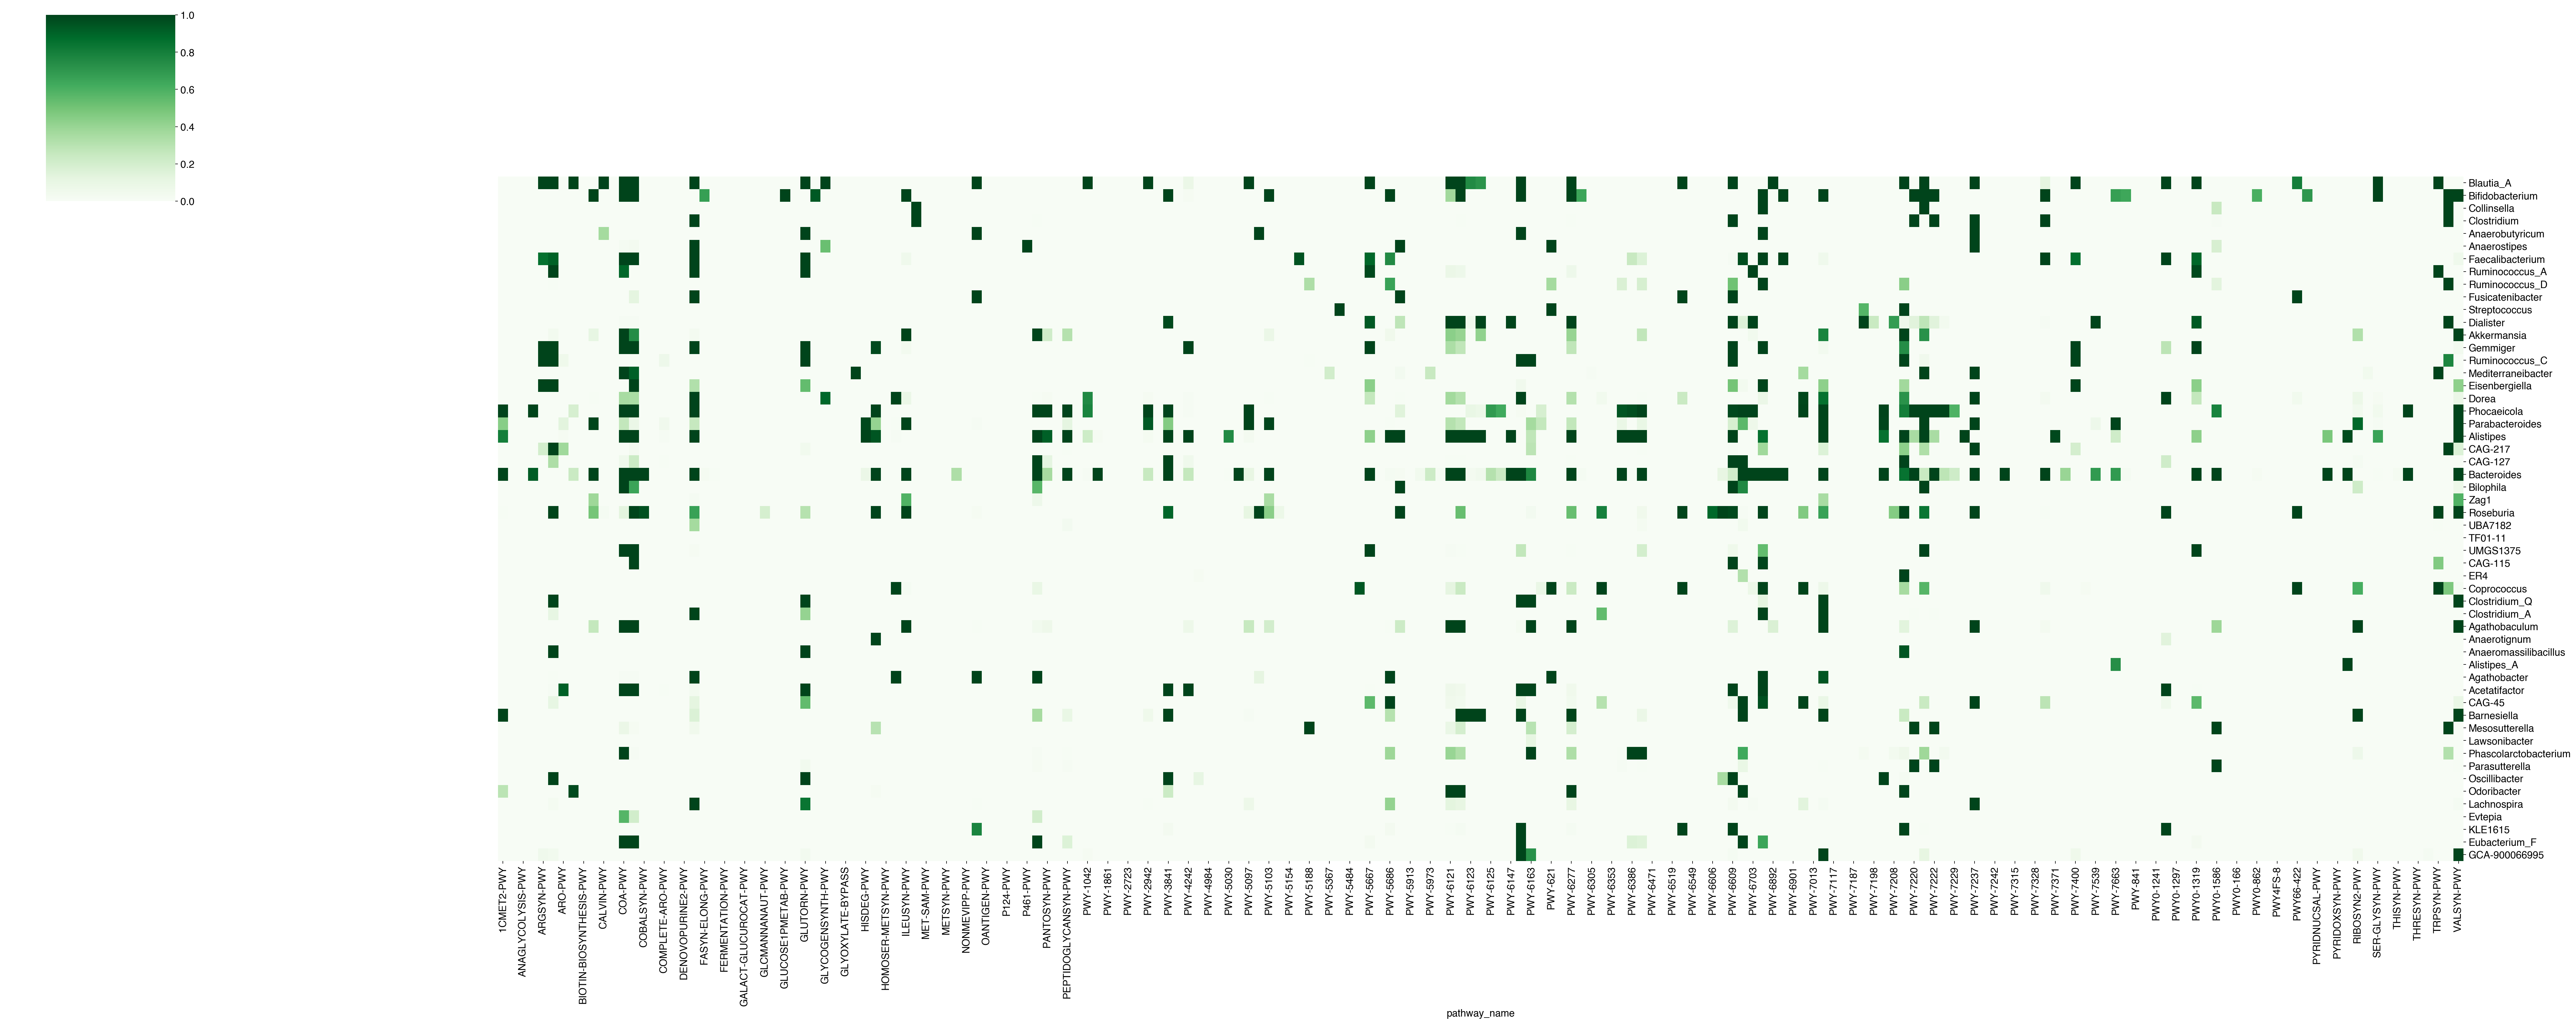

In [420]:
# plot the heatmap of the pathway coverage
ordered_cluster_all = cluster_sc_group_df.sort_values('counts',  ascending=False).index.tolist()
ordered_cluster_with_path = []
for c in ordered_cluster_all:
    
    if (c.split('__')[1]) in cluster_with_path:
        ordered_cluster_with_path.append(c.split('__')[1])
        
        
ax = sns.clustermap(path_cov_2[ordered_cluster_with_path].T, 
               cmap='Greens', 
               row_cluster=False, 
               col_cluster=False,

                    vmax = 1,  
                    figsize=(50,20)
              )

### Top 2 genus sub-clustering with species abundance result from Kracken

In [330]:
# top2 cluster with the most barcode count 
top2 = ['g__Blautia_A', 'g__Bifidobacterium']


In [335]:
kraken_dir = '/drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/'
bracken_db = '/drive1/xiangpeng/reference/kraken2/GTDB_release95/bracken/'

for g in top2:
    top2_s_bracken_df = pd.DataFrame()
    idx_ls = cluster_df[(cluster_df['cell_type_2']==g)&(cluster_df['batch']=='single_cell')].index.tolist()
    #print(idx_ls)
    for idx in idx_ls:
        try:
            bar =  idx.split('-single')[0]
            rpt = kraken_dir + bar + '.kraken'
            braken_s = kraken_dir + bar + '_S.bracken'
            brk_cmd =  'bracken -d {} -l S -i {} -o {}'.format(kraken_db,rpt,braken_s) # use -l S to access the species level abundance
            print(brk_cmd)
            #os.system(brk_cmd)
            
            df = pd.read_csv(braken_s, sep = '\t')
            df = df.set_index('name')
            df = df.rename(columns = {'fraction_total_reads': bar})
            top2_s_bracken_df=pd.concat([top2_s_bracken_df, df[bar]], axis = 1)

        except FileNotFoundError:
            print('{} did not found'.format(braken_s))
            
    top2_s_bracken_df = top2_s_bracken_df.fillna(0)
    top2_s_bracken_df.to_csv('{}{}_species_level_kraken_abandance.csv'.format(kraken_dir, g))
    

bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/AACACACTCCTCCTATCT-2.kraken -o /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/AACACACTCCTCCTATCT-2_S.bracken
bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/AACCATGGTTTAAGTGGT-2.kraken -o /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/AACCATGGTTTAAGTGGT-2_S.bracken
bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/AACGATGACGAGTTAACT-2.kraken -o /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/AACGATGACGAGTTAACT-2_S.bracken
bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novos

bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/AGCATTGTTGTATTACTG-1.kraken -o /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/AGCATTGTTGTATTACTG-1_S.bracken
bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/AGCATTGTTTATTACTCG-1.kraken -o /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/AGCATTGTTTATTACTCG-1_S.bracken
bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/AGCCACTTCCATCCTCTC-2.kraken -o /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/AGCCACTTCCATCCTCTC-2_S.bracken
bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novos

bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/ATCTTACAGTCACGCGAC-1.kraken -o /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/ATCTTACAGTCACGCGAC-1_S.bracken
bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/ATGCGCTACCTATGGATG-2.kraken -o /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/ATGCGCTACCTATGGATG-2_S.bracken
bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/ATGCTCACCACCACGCTA-2.kraken -o /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/ATGCTCACCACCACGCTA-2_S.bracken
bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novos

bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/CCTCTTGTAGAGGTCACG-2.kraken -o /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/CCTCTTGTAGAGGTCACG-2_S.bracken
bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/CCTGTCATTAATATCGCT-2.kraken -o /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/CCTGTCATTAATATCGCT-2_S.bracken
bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/CGACAGACCGATCGTTGA-1.kraken -o /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/CGACAGACCGATCGTTGA-1_S.bracken
bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novos

bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/GATGCGGTTCGTGTCCGA-2.kraken -o /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/GATGCGGTTCGTGTCCGA-2_S.bracken
bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/GATGCGGTTGTGTCCGTG-2.kraken -o /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/GATGCGGTTGTGTCCGTG-2_S.bracken
bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/GATGCGGTTTTGGTAACT-2.kraken -o /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/GATGCGGTTTTGGTAACT-2_S.bracken
bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novos

bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/GGAGAATGATCCTATTCC-2.kraken -o /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/GGAGAATGATCCTATTCC-2_S.bracken
bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/GGAGCTCAATAATCACGC-2.kraken -o /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/GGAGCTCAATAATCACGC-2_S.bracken
bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/GGATGCGAAGTCAATACA-2.kraken -o /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/GGATGCGAAGTCAATACA-2_S.bracken
bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novos

bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/TCCACGTGCCTGTGGTGG-2.kraken -o /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/TCCACGTGCCTGTGGTGG-2_S.bracken
bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/TCCGATAACCACCTAGCG-2.kraken -o /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/TCCGATAACCACCTAGCG-2_S.bracken
bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/TCCGATAACCGACCTAGC-2.kraken -o /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/TCCGATAACCGACCTAGC-2_S.bracken
bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novos

bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/TTATTCGACCGCAACCTC-1.kraken -o /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/TTATTCGACCGCAACCTC-1_S.bracken
bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/TTATTCGACGCAACCAAC-1.kraken -o /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/TTATTCGACGCAACCAAC-1_S.bracken
bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/TTCACTCCTCGACAGGAA-2.kraken -o /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/TTCACTCCTCGACAGGAA-2_S.bracken
bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novos

bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/AGGTCAGCACTGTGCTCA-1.kraken -o /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/AGGTCAGCACTGTGCTCA-1_S.bracken
bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/AGTAGAGGACCAAGTCGA-1.kraken -o /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/AGTAGAGGACCAAGTCGA-1_S.bracken
bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/AGTATGACGGATTGGAAG-2.kraken -o /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/AGTATGACGGATTGGAAG-2_S.bracken
bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novos

bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/CCAACAACACGTACACAC-2.kraken -o /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/CCAACAACACGTACACAC-2_S.bracken
bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/CCACTTCGCTTCGCATCC-2.kraken -o /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/CCACTTCGCTTCGCATCC-2_S.bracken
/drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/CCACTTCGCTTCGCATCC-2_S.bracken did not found
bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/CCAGGAGTTTAACATTGG-1.kraken -o /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/CCAGGAGTTTAACATTGG-1_S.brac

bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/GCAACCAACCTATCCATC-2.kraken -o /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/GCAACCAACCTATCCATC-2_S.bracken
bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/GCCACATGGATCCGGTCC-1.kraken -o /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/GCCACATGGATCCGGTCC-1_S.bracken
bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/GCCACATGGCTAACCGGT-1.kraken -o /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/GCCACATGGCTAACCGGT-1_S.bracken
bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novos

bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/TGAACGTCATAGCACTAT-1.kraken -o /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/TGAACGTCATAGCACTAT-1_S.bracken
bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/TGACGATGAGATACCGGA-1.kraken -o /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/TGACGATGAGATACCGGA-1_S.bracken
bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/TGAGAATCCTCGGACAGT-2.kraken -o /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/kraken_gtdb/TGAGAATCCTCGGACAGT-2_S.bracken
bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/ -l S -i /drive4/xiangpeng/Project/bacteria/novos

In [338]:
Blautia_A_s_bracken = pd.read_csv(kraken_dir + 'g__Blautia_A_species_level_kraken_abandance.csv',index_col = 0)
Bifidobacterium_s_bracken = pd.read_csv(kraken_dir + 'g__Bifidobacterium_species_level_kraken_abandance.csv',index_col = 0)


In [344]:
adata_Blautia_A =  anndata.AnnData(Blautia_A_s_bracken.T, dtype =np.float32)
adata_Bifidobacterium =  anndata.AnnData(Bifidobacterium_s_bracken.T,dtype =np.float32)



computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


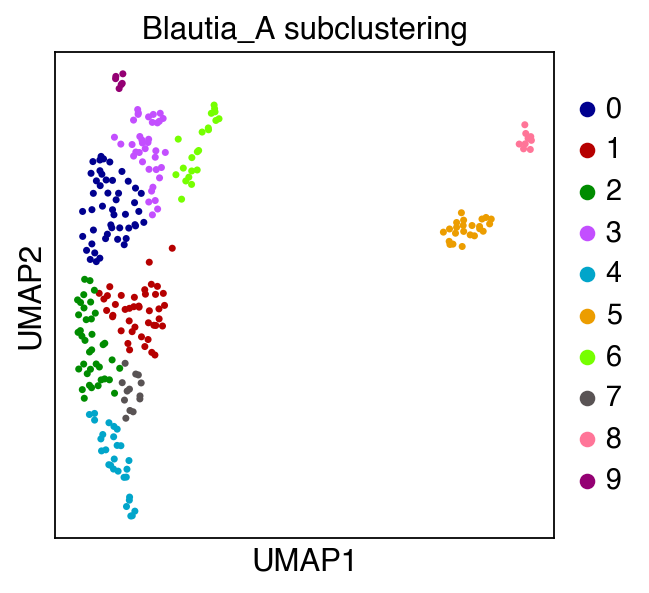

In [349]:
sc.pp.neighbors(adata_Blautia_A, use_rep='X')
sc.tl.leiden(adata_Blautia_A)
sc.tl.umap(adata_Blautia_A)
with plt.rc_context({"figure.figsize": (4, 4)}):
    sc.pl.umap(adata_Blautia_A, color='leiden', s = 40, 
               frameon=True, 
               title='Blautia_A subclustering',
               save = 'hm3_top3_cluster_species_level_blautia.pdf')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


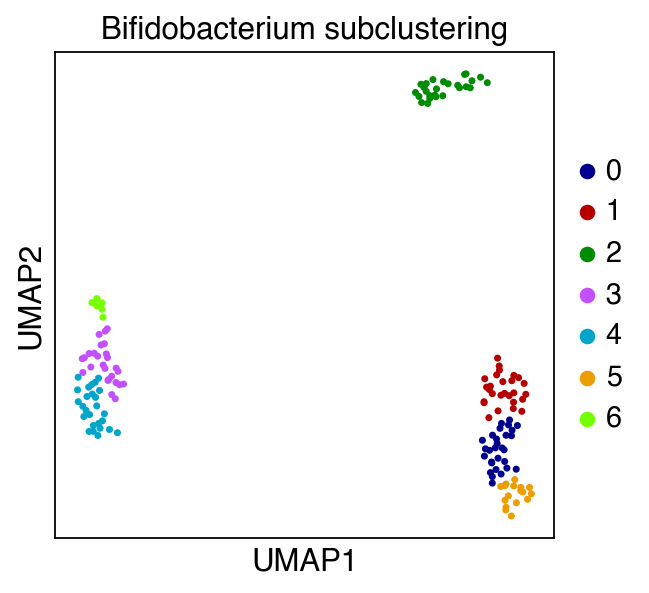

In [350]:
sc.pp.neighbors(adata_Bifidobacterium, use_rep='X')
sc.tl.leiden(adata_Bifidobacterium)
sc.tl.umap(adata_Bifidobacterium)
with plt.rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata_Bifidobacterium, color='leiden', 
               s = 40,frameon=True, 
               title='Bifidobacterium subclustering',
               save = 'hm3_top3_cluster_species_level_bifido.pdf')

### Antibiotic resistance 

#### antibiotic resistant genes database
(CARD 2020: antibiotic resistome surveillance with the Comprehensive
Antibiotic Resistance Database" Nucleic Acids Research, 48: D517-D525,
https://www.ncbi.nlm.nih.gov/pubmed/31665441)
https://card.mcmaster.ca/download 3.1.4  2021-10-05 10:24:15.645117

bowtie2 index file: '/drive1/xiangpeng/reference/antibiotic_resistance_genes/bt2/arg'

use botiew2 to map the combined cluster fastq to CARD

In [393]:
arg_ref ='/drive1/xiangpeng/reference/antibiotic_resistance_genes/bt2/arg'
sc_dir = '/drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell/'
arg_out_dir = '/drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell_genes3/arg/'
from pandas.errors import EmptyDataError

arg_pd = pd.DataFrame()

for c in cluster_ID_ls:
    fq1 = sc_dir + c + '/' + c +'/R1_combined.fastq'
    fq2 = sc_dir + c + '/' + c +'/R2_combined.fastq'
    out_bam = arg_out_dir + c +'_arg.bam'
    
    bt2_cmd = 'bowtie2 -p 32 -x {} -1 {} -2 {} | samtools view -bS -q 42  > {}'.format(arg_ref, fq1, fq2, out_bam)
    print(bt2_cmd)
    #os.system(bt2_cmd)
    
    ## sort the bam file. 
    srt_bam = arg_out_dir + c +'_arg_srt.bam' 
    srt_cmd = 'samtools sort -O BAM -o {} {}'.format(srt_bam, out_bam)
    print(srt_cmd)
    #os.system(srt_cmd)
    
    ## remove duplicate from the bam file
    rmdup_bam = arg_out_dir + c +'_arg_rmdup.bam' 
    rmdup_cmd = 'samtools rmdup -S {} {}'.format(srt_bam, rmdup_bam) 
    print(rmdup_cmd)
    #os.system(rmdup_cmd)
    
    ## extract the mapped read count form the bam files
    cnt_txt = arg_out_dir + c +'_arg.txt' 
    uniq_cnt_cmd = 'samtools view {} |cut -f 3 | sort | uniq -c | sort -nr > {}'.format(rmdup_bam, cnt_txt)
    print(uniq_cnt_cmd)
    #os.system(uniq_cnt_cmd)
    
    ## combine all the output of arg 
    names = [c,'gb', 'DNA_accession', 'strand', 'location', 'arg', 'target']
    try:
        df = pd.read_csv(cnt_txt,engine='python',sep = '\s+|\|',  names=names)
        df = df.set_index('arg')
        read_cnt = cluster_stat.loc[c,'sc_read_cnt']
        df[c] = df[c]/(read_cnt/1000000) # unique reads per million total reads
        arg_pd = pd.concat([arg_pd, df[c]],axis =1,)
    except:
        continue

arg_pd = arg_pd.fillna(0)
arg_pd.head()

bowtie2 -p 32 -x /drive1/xiangpeng/reference/antibiotic_resistance_genes/bt2/arg -1 /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell/g__Acetatifactor/g__Acetatifactor/R1_combined.fastq -2 /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell/g__Acetatifactor/g__Acetatifactor/R2_combined.fastq | samtools view -bS -q 42  > /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell_genes3/arg/g__Acetatifactor_arg.bam
samtools sort -O BAM -o /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell_genes3/arg/g__Acetatifactor_arg_srt.bam /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell_genes3/arg/g__Acetatifactor_arg.bam
samtools rmdup -S /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell_genes3/arg/g__Acetatifactor_arg_srt.bam /drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/single_cell_genes3/arg/g__Acetatifactor_arg_rmdup.bam
samtools view /drive1/xiangpeng/Project/bacteria/HM3/assembly

,g__Akkermansia,g__Alistipes,g__Anaerobutyricum,g__Anaerostipes,g__Azonexus,g__Bacteroides,g__Bifidobacterium,g__Bilophila,g__Blautia,g__Blautia_A,...,g__Mediterraneibacter,g__Parabacteroides,g__Phocaeicola,g__Prevotella,g__Ruminococcus_A,g__Ruminococcus_C,g__Ruminococcus_D,g__Sediminibacterium,g__Senegalimassilia,g__Streptococcus
ARO:3000190,0,0,3.672312,0.000000,0.000000,0,0.062015,0,0,3.016459,...,0.0,0,0,0,0.000000,0,0.000000,0.000000,0,0.000000
ARO:3004480,0,0,0.734462,0.664630,4.515978,0,11.751918,0,0,0.486962,...,0.0,0,0,0,0.000000,0,1.106363,0.000000,0,0.000000
ARO:3004601,0,0,0.293785,0.332315,0.000000,0,0.062015,0,0,0.081160,...,0.0,0,0,0,0.327338,0,0.000000,2.230281,0,0.306856
ARO:3000196,0,0,0.293785,0.000000,0.000000,0,0.000000,0,0,0.027053,...,0.0,0,0,0,0.000000,0,0.000000,0.000000,0,0.000000
ARO:3000567,0,0,0.293785,0.000000,0.000000,0,0.062015,0,0,0.216428,...,0.0,0,0,0,0.000000,0,0.000000,0.000000,0,0.000000


<AxesSubplot:>

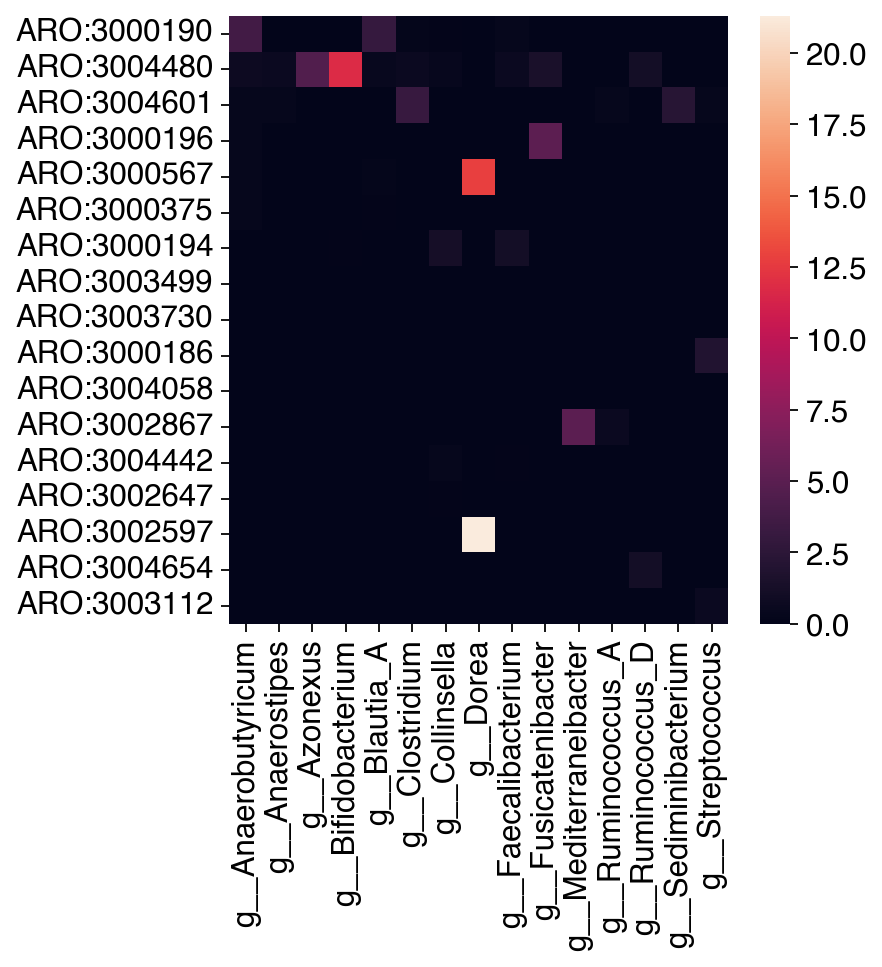

In [401]:
arg_pd = arg_pd.loc[:, (arg_pd != 0).any(axis=0)]


sns.heatmap(arg_pd, 
            #cmap= 'Reds',
            #norm =LogNorm()
           )

In [403]:
# add tree to the interaction map
gtdb_dir ='/drive1/xiangpeng/reference/kraken2/GTDB_release95/from_gtdb/'
gtdb_meta=gtdb_dir+'bac120_metadata_r95.tsv'
gtdb_meta_df = pd.read_csv(gtdb_meta, sep= '\t',
                           on_bad_lines='skip'
                          )

/tmp/ipykernel_83508/11847364.py:4: DtypeWarning: Columns (61,65,74,82,83) have mixed types. Specify dtype option on import or set low_memory=False.
  gtdb_meta_df = pd.read_csv(gtdb_meta, sep= '\t',


In [421]:
gtdb_meta_df = gtdb_meta_df.loc[:,[ 'gtdb_taxonomy','ncbi_taxid', ]]
gtdb_meta_df['ncbi_taxid'] = gtdb_meta_df['ncbi_taxid'].apply(int)

gtdb_meta_df[['D','P','C','O','F','G', 'S']]=gtdb_meta_df['gtdb_taxonomy'].str.split(';', expand=True)
gtdb_meta_df= gtdb_meta_df.set_index('G')

gtdb_to_ncbi_dict = gtdb_meta_df['ncbi_taxid'].to_dict()

In [436]:
genus_ls = arg_pd.columns.tolist()
id_genus = {}
id_ls = []
for g in genus_ls:
    ncbi_id = gtdb_to_ncbi_dict[g]
    id_genus[ncbi_id] = g
    id_ls.append(ncbi_id)
print(id_genus)
print(id_ls)

{39488: 'g__Anaerobutyricum', 411490: 'g__Anaerostipes', 146940: 'g__Azonexus', 1685: 'g__Bifidobacterium', 1917876: 'g__Blautia_A', 1502: 'g__Clostridium', 74426: 'g__Collinsella', 2086584: 'g__Dorea', 853: 'g__Faecalibacterium', 2292982: 'g__Fusicatenibacter', 1871020: 'g__Mediterraneibacter', 2509240: 'g__Ruminococcus_A', 2364796: 'g__Ruminococcus_D', 413434: 'g__Sediminibacterium', 28037: 'g__Streptococcus'}
[39488, 411490, 146940, 1685, 1917876, 1502, 74426, 2086584, 853, 2292982, 1871020, 2509240, 2364796, 413434, 28037]


In [437]:
print(right_order_ncbiID)

[413434, 146940, 1685, 74426, 28037, 2086584, 1502, 1871020, 853, 2364796, 411490, 39488, 2509240, 2292982, 1917876]


In [439]:
# use the id_ls to generate a taxa tree using phyloT (https://phylot.biobyte.de/)
# the reorder the genus in the datafram to fit the order of the tree.
right_order_ncbiID = [413434,146940,1685,74426,28037,2086584,1502,1871020, 853,2364796,411490,39488,2509240,2292982,1917876]
right_order=[]
for ncbiid in right_order_ncbiID:
    g = id_genus[ncbiid]
    right_order.append(g)
    
arg_pd=arg_pd[right_order]

In [443]:
### find out the mechanism of ARO
aro_index_dir = '/drive1/xiangpeng/reference/antibiotic/'
aro_index_df = pd.read_csv(aro_index_dir + 'aro_index.tsv', sep='\t').set_index('ARO Accession')
aro_mech_dict = aro_index_df['Resistance Mechanism'].to_dict()
aro_index_df.head()

,CVTERM ID,Model Sequence ID,Model ID,Model Name,ARO Name,Protein Accession,DNA Accession,AMR Gene Family,Drug Class,Resistance Mechanism
ARO Accession,,,,,,,,,,
ARO:3005099,43314,6143,3831,23S rRNA (adenine(2058)-N(6))-methyltransferas...,23S rRNA (adenine(2058)-N(6))-methyltransferas...,AAB60941.1,AF002716.1,Erm 23S ribosomal RNA methyltransferase,lincosamide antibiotic;macrolide antibiotic;st...,antibiotic target alteration
ARO:3000317,36456,51,874,AAC(1),AAC(1)-I,ADH03009.1,HM036080,AAC(1),aminoglycoside antibiotic,antibiotic inactivation
ARO:3002523,38923,53,1781,AAC(2')-Ia,AAC(2')-Ia,AAA03550.1,L06156,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation
ARO:3002524,38924,85,746,AAC(2')-Ib,AAC(2')-Ib,AAC44793.1,U41471,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation
ARO:3002525,38925,4719,1246,AAC(2')-Ic,AAC(2')-Ic,CCP42991.1,AL123456.3,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation


In [445]:
# select the args that code proteins
arg_pd_proteins = pd.concat([arg_pd, aro_index_df.loc[arg_pd.index]], axis =1, join = 'inner')
arg_pd_proteins =  arg_pd_proteins[arg_pd_proteins['Protein Accession'].notna()]
arg_pd_proteins.head()

,g__Sediminibacterium,g__Azonexus,g__Bifidobacterium,g__Collinsella,g__Streptococcus,g__Dorea,g__Clostridium,g__Mediterraneibacter,g__Faecalibacterium,g__Ruminococcus_D,...,CVTERM ID,Model Sequence ID,Model ID,Model Name,ARO Name,Protein Accession,DNA Accession,AMR Gene Family,Drug Class,Resistance Mechanism
ARO:3000190,0.000000,0.000000,0.062015,0.160243,0.000000,0.000000,0.22005,0.0,0.322227,0.000000,...,36329,4234,2020,tetO,tetO,AAA23033.2,M18896.2,tetracycline-resistant ribosomal protection pr...,tetracycline antibiotic,antibiotic target protection
ARO:3004480,0.000000,4.515978,11.751918,0.373899,0.000000,0.000000,0.66015,0.0,0.644455,1.106363,...,41743,5874,2914,Bifidobacterium adolescentis rpoB conferring r...,Bifidobacterium adolescentis rpoB mutants conf...,WP_041777404.1,NC_008618.1,rifamycin-resistant beta-subunit of RNA polyme...,peptide antibiotic;rifamycin antibiotic,antibiotic target alteration;antibiotic target...
ARO:3004601,2.230281,0.000000,0.062015,0.053414,0.306856,0.000000,3.08070,0.0,0.000000,0.000000,...,42534,5200,3301,LnuP,LnuP,ACS83559.1,FJ589781.1,lincosamide nucleotidyltransferase (LNU),lincosamide antibiotic,antibiotic inactivation
ARO:3000196,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,...,36335,5146,1233,tet32,tet32,ACH87088.1,EU722333.1,tetracycline-resistant ribosomal protection pr...,tetracycline antibiotic,antibiotic target protection
ARO:3000567,0.000000,0.000000,0.062015,0.000000,0.000000,12.780533,0.00000,0.0,0.000000,0.000000,...,36706,5150,945,tet(40),tet(40),CAM12479.1,AM419751,major facilitator superfamily (MFS) antibiotic...,tetracycline antibiotic,antibiotic efflux


In [454]:
new_idx =[]
for idx in arg_pd.index.tolist():
    if idx in arg_pd_proteins.index.tolist():
        new_idx.append(idx)
print(new_idx)
arg_pd_proteins = arg_pd_proteins.loc[new_idx]

['ARO:3000190', 'ARO:3004480', 'ARO:3004601', 'ARO:3000196', 'ARO:3000567', 'ARO:3000375', 'ARO:3000194', 'ARO:3003730', 'ARO:3000186', 'ARO:3002867', 'ARO:3004442', 'ARO:3002647', 'ARO:3002597', 'ARO:3003112']


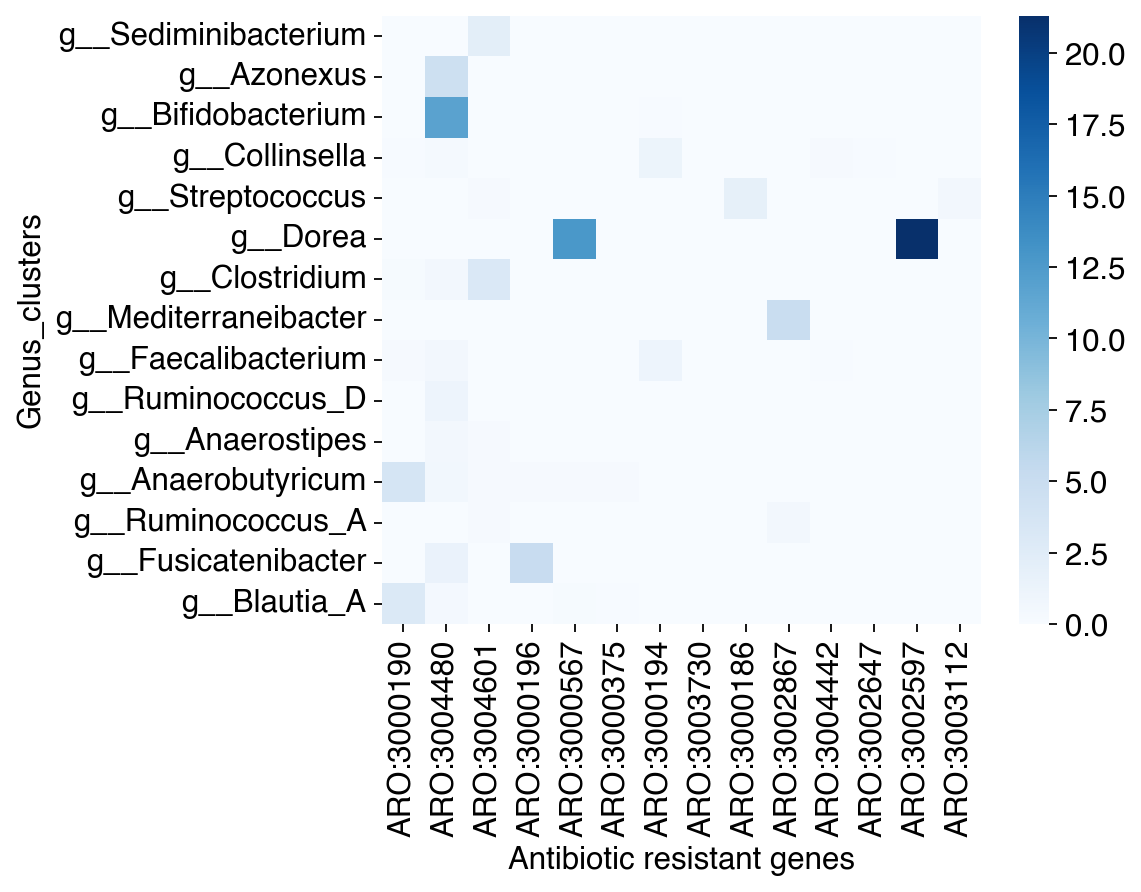

In [455]:
# plot
plt.figure(figsize=(6,5))
ax =sns.heatmap(arg_pd_proteins[arg_pd.columns][right_order].T, cmap ='Blues')
ax.set_facecolor('grey')
plt.ylabel('Genus_clusters')
plt.xlabel('Antibiotic resistant genes')
plt.savefig(output_dir+'hm3_cluster_arg_heatmap_reanalysis_protein_only_2.pdf' ,bbox_inches='tight')


In [456]:
arg_pd_proteins.to_csv(output_dir+'hm3_cluster_arg_heatmap_protein.tsv')